# APM Assignment 1

**Submitted by**

    Aaron Berger (433386)
    Aravind Sankaran (351286)
    Hans Vrapi (384652)

In [1]:
import os
import pandas as pd
import datetime

In [3]:
import pm4py

## Log Util
# Log conversion
from pm4py.objects.conversion.log import converter as log_converter
# Read Log (e.g., If you can not use the simplified interface because you do not have ipywidgets installed)
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.log.obj import EventLog
from pm4py.objects.log.util.log import get_event_labels
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.algo.filtering.log.variants import variants_filter

# Filter Log on End Activities
from pm4py.algo.filtering.log.end_activities import end_activities_filter

## Conformance Checking
# Token-based replay (e.g., If you can not use the simplified interface because you do not have ipywidgets installed)
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
# Standard Alignments (e.g., If you can not use the simplified interface because you do not have ipywidgets installed)
from pm4py.algo.conformance.alignments import algorithm as alignments
# Footprint
from pm4py.algo.conformance.footprints import algorithm as footprints_conformance
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery
from pm4py.visualization.footprints import visualizer as fp_visualizer
from pm4py.algo.conformance.footprints.util import evaluation

from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

## Petri Nets
from pm4py.objects.petri_net.obj import PetriNet, Marking
from pm4py.objects.petri_net.utils import petri_utils, check_soundness
from pm4py.objects.petri_net.importer import importer as pnml_importer
from pm4py.objects.petri_net.exporter import exporter as pnml_exporter
from pm4py.visualization.petri_net import visualizer as pn_visualizer

## Decision Trees
from sklearn import tree
from pm4py.visualization.decisiontree import visualizer as dectree_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.algo.transformation.log_to_features import algorithm as log_to_features
from pm4py.objects.log.util import get_class_representation

## Process Discovery
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner

from pm4py.objects.log.util.log import get_event_labels_counted
from pm4py.statistics.traces.generic.log import case_statistics
from pm4py.objects.log.util import get_log_representation
from pm4py.objects.log.util import get_class_representation

### Other Requirements

    numpy
    seaborn
    matplotlib

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### PM4Py version

In [5]:
pm4py.__version__

'2.2.21'

### Set the ROOT folder containing the log files

In [7]:
LOG_ROOT = "logs/"
MODELS_FOLDER = "models/"

# Question 1:  Process Overview

#### Read log "log_vaccination.xes"

In [8]:
log = pm4py.read_xes(os.path.join(LOG_ROOT, "log_vaccination.xes"))

/Users/aravind/exercise/PyCharmProjects/APM/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4960/4960 [00:04<00:00, 1035.17it/s]


## Question 1a

#### Number of cases

In [9]:
number_of_cases = len(log)
print("Number of cases: {}".format(number_of_cases))

Number of cases: 4960


####  Activities count

In [10]:
get_event_labels_counted(log, key='concept:name')

{'Enter into System': 4861,
 'Insurance Check Private': 1615,
 'Notify about vacc. possibility': 5557,
 'Acknowledge vacc. possibility': 4206,
 'Request appointment': 4640,
 'Appointment granted': 4231,
 'Prepare vaccine': 8388,
 'Send vaccine to cabine': 8388,
 'Register at vaccination facillity': 8385,
 'Finished Risk Talk': 4271,
 'Submit Declaration': 8318,
 'Vaccinate': 8301,
 'Checkout': 8317,
 'Priority Appointment granted': 4173,
 'Send Invoice': 1619,
 'Send Vaccination Certificate': 3697,
 'Decline vaccination': 561,
 'Insurance Check Statutory': 3253,
 'Destroy Vacc': 83,
 'Checkout No Vacc': 85}

#### Min, Max and Average activities in each trace

In [11]:
def get_min_max_avg_activities(variants):
    num_events = []
    for variant in variants:
        n = [len(variant['variant'].split(','))]*variant['count']
        num_events = num_events + n
    return {
        'min': min(num_events),
        'max': max(num_events),
        'avg': np.mean(num_events)
    }

variants_count = case_statistics.get_variant_statistics(log)
get_min_max_avg_activities(variants_count)

{'min': 3, 'max': 35, 'avg': 18.739717741935483}

#### Distribution of case duration

/var/folders/sv/jmmtzklx49g03qzbkrpz_cdr0000gp/T/ipykernel_53046/2350193742.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(datetime.timedelta(seconds=tm)) for tm in xticks],


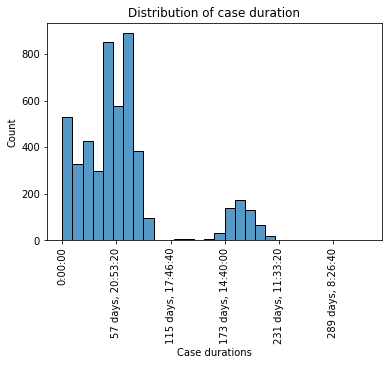

In [12]:
all_case_durations = case_statistics.get_all_case_durations(log, parameters={
    case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"})

f = plt.figure()
ax = f.add_subplot(1,1,1)
sns.histplot(np.array(all_case_durations),ax=ax, bins=30)
xticks = ax.get_xticks()
ax.set_xticklabels([str(datetime.timedelta(seconds=tm)) for tm in xticks],
 rotation=90)
ax.set_xlabel("Case durations")
ax.set_title("Distribution of case duration")
plt.show()

# Question 2: Process Discovery

## Question 2a

### Filter log containing only finished cases

#### Number of cases in the filtered log 

In [13]:
print(f'Initial number of cases: {len(log)}')

#filter the event data on end activities
end_activities = end_activities_filter.get_end_activities(log)
filtered_end_activities =  ['Checkout No Vacc',
                            'Decline vaccination',
                            'Destroy Vacc',
                            'Notify about vacc. possibility',
                            'Send Vaccination Certificate',      
                            ]
filtered_log = end_activities_filter.apply(log, filtered_end_activities)
print(f'Number of cases after filtering: {len(filtered_log)}')

print(f'Number of removed cases: {len(log)- len(filtered_log)}')

Initial number of cases: 4960
Number of cases after filtering: 3978
Number of removed cases: 982


#### Set of end activities for removed traces

In [14]:
filtered_log2 = end_activities_filter.apply(log, filtered_end_activities,
                                          parameters={end_activities_filter.Parameters.POSITIVE: False,})
end_activities_filter.get_end_activities(filtered_log2)

{'Send Invoice': 341,
 'Checkout': 628,
 'Vaccinate': 6,
 'Priority Appointment granted': 7}

#### Activities in finished cases

In [15]:
get_event_labels_counted(filtered_log, key='concept:name')

{'Enter into System': 3902,
 'Insurance Check Private': 1255,
 'Notify about vacc. possibility': 4486,
 'Acknowledge vacc. possibility': 3250,
 'Request appointment': 3581,
 'Appointment granted': 3269,
 'Prepare vaccine': 6423,
 'Send vaccine to cabine': 6423,
 'Register at vaccination facillity': 6423,
 'Finished Risk Talk': 3298,
 'Submit Declaration': 6351,
 'Vaccinate': 6348,
 'Checkout': 6353,
 'Priority Appointment granted': 3163,
 'Send Invoice': 1212,
 'Send Vaccination Certificate': 3566,
 'Decline vaccination': 554,
 'Insurance Check Statutory': 2652,
 'Destroy Vacc': 83,
 'Checkout No Vacc': 85}

#### Number of Variants

In [16]:
variants = variants_filter.get_variants(filtered_log)
len(variants)

409

## Question 2b

### Discover models on log containing finished cases

In [17]:
def discover_models_and_qualities(log,model_sub_folder, net_list):
    # read the petri nets discovered using each algorithm
    columns = ['Model',
            'Fitness-Token',
             'Fitness-Alignment',
             'Precision-Token',
             'Precision-Alignment',
             'Generalization',
             'Simplicity']

    data = pd.DataFrame(columns=columns)
    gviz_models = {}

    for model, name in net_list:

        ## DISCOVER MODEL
        net, im, fm = pnml_importer.apply(os.path.join(MODELS_FOLDER, model_sub_folder, f"{name}.pnml"))
        print(f'Model discovered by {model}: ')

        gviz_models[name] = pn_visualizer.apply(net,im,fm)
        #pt_visualizer.view(gviz)
        #compute the quality dimension for each model

        ## Fitness
        fitness_tb = replay_fitness_evaluator.apply(log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
        try:
            fitness_ab = replay_fitness_evaluator.apply(log, net, im, fm, 
                                                                      variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)['log_fitness']
        except:
            fitness_ab = -1

        ## Precision
        prec_tb = precision_evaluator.apply(log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
        try:
            prec_ab =  precision_evaluator.apply(log, net, im, fm, variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE)
        except:
            prec_ab = -1

        ## Generalization
        gen = generalization_evaluator.apply(log, net, im, fm)

        ##Simplicity
        simp = simplicity_evaluator.apply(net)

        df = pd.DataFrame([[model, fitness_tb['log_fitness'], fitness_ab, prec_tb, prec_ab, gen, simp]], columns=columns)    
        data = pd.concat([data,df], ignore_index=True)
        
    return data, gviz_models
    

In [18]:
finished_log = pm4py.read_xes(os.path.join(LOG_ROOT, "log_vaccination_finished_cases.xes"))

net_list = [('Inductive Miner', 'net_im'), ('Heuristic Miner', 'net_hm'), ('Alpha Miner', 'net_alpha'), ('ILP Miner', 'net_ilp'), ('State Region Miner', 'net_sr')]
data, gviz_models = discover_models_and_qualities(finished_log, "2b", net_list)

parsing log, completed traces :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3978/3978 [00:03<00:00, 1009.51it/s]


Model discovered by Inductive Miner: 


replaying log with TBR, completed variants :: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2925/2925 [00:01<00:00, 2085.63it/s]
computing precision with alignments, completed variants :: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2925/2925 [00:06<00:00, 468.53it/s]
replaying log with TBR, completed variants :: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 409/409 [00:00<00:00, 668.30it/s]


Model discovered by Heuristic Miner: 


replaying log with TBR, completed variants :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2925/2925 [00:06<00:00, 461.42it/s]
computing precision with alignments, completed variants :: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2925/2925 [00:15<00:00, 185.19it/s]
replaying log with TBR, completed variants :: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 409/409 [00:01<00:00, 241.88it/s]


Model discovered by Alpha Miner: 


replaying log with TBR, completed variants :: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 409/409 [00:00<00:00, 460.68it/s]


Model discovered by ILP Miner: 


replaying log with TBR, completed variants :: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2925/2925 [00:01<00:00, 2214.64it/s]
computing precision with alignments, completed variants :: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2925/2925 [00:10<00:00, 276.82it/s]
replaying log with TBR, completed variants :: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 409/409 [00:00<00:00, 471.57it/s]


Model discovered by State Region Miner: 


replaying log with TBR, completed variants :: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 409/409 [00:00<00:00, 459.12it/s]


### Display Models

#### 1) Inductive miner

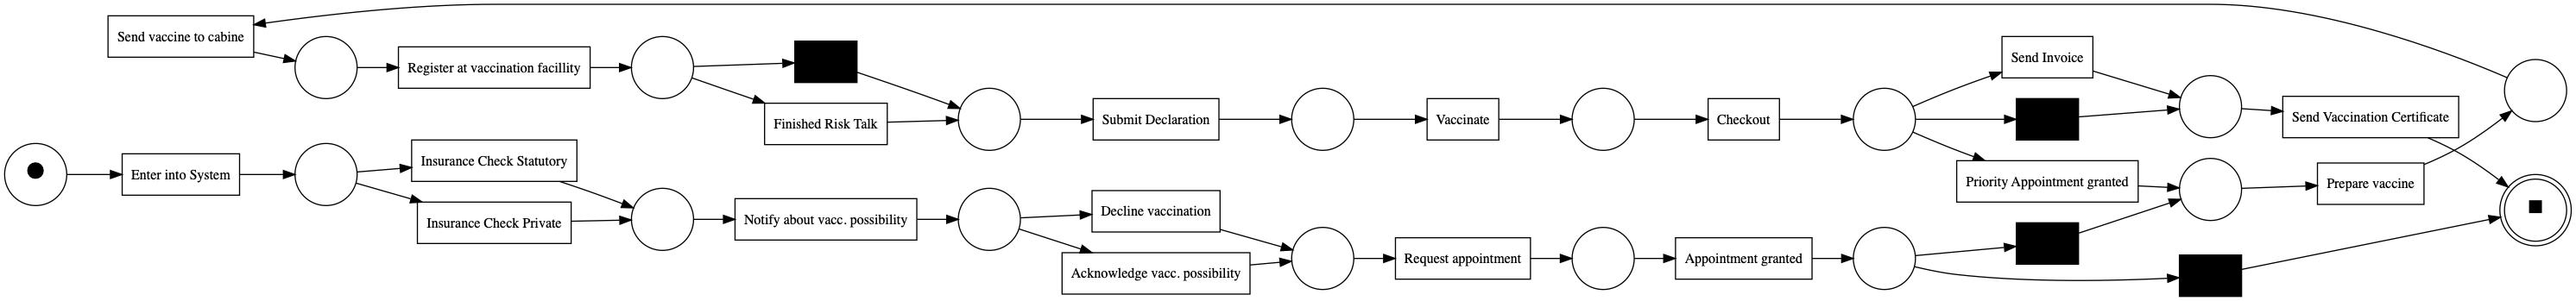

In [20]:
pt_visualizer.view(gviz_models['net_im'])

#### 2) Heuristic Miner

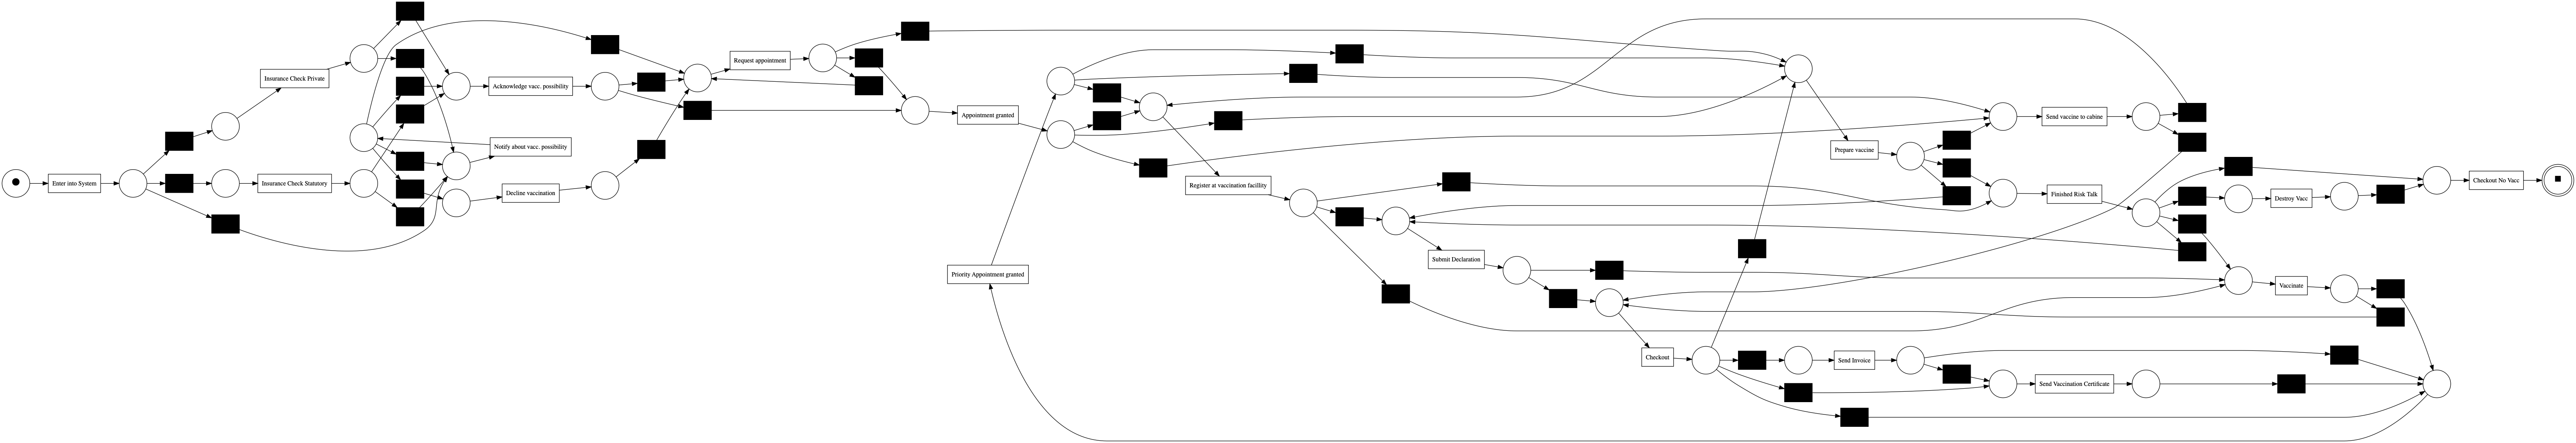

In [21]:
pt_visualizer.view(gviz_models['net_hm'])

#### 3) Alpha miner

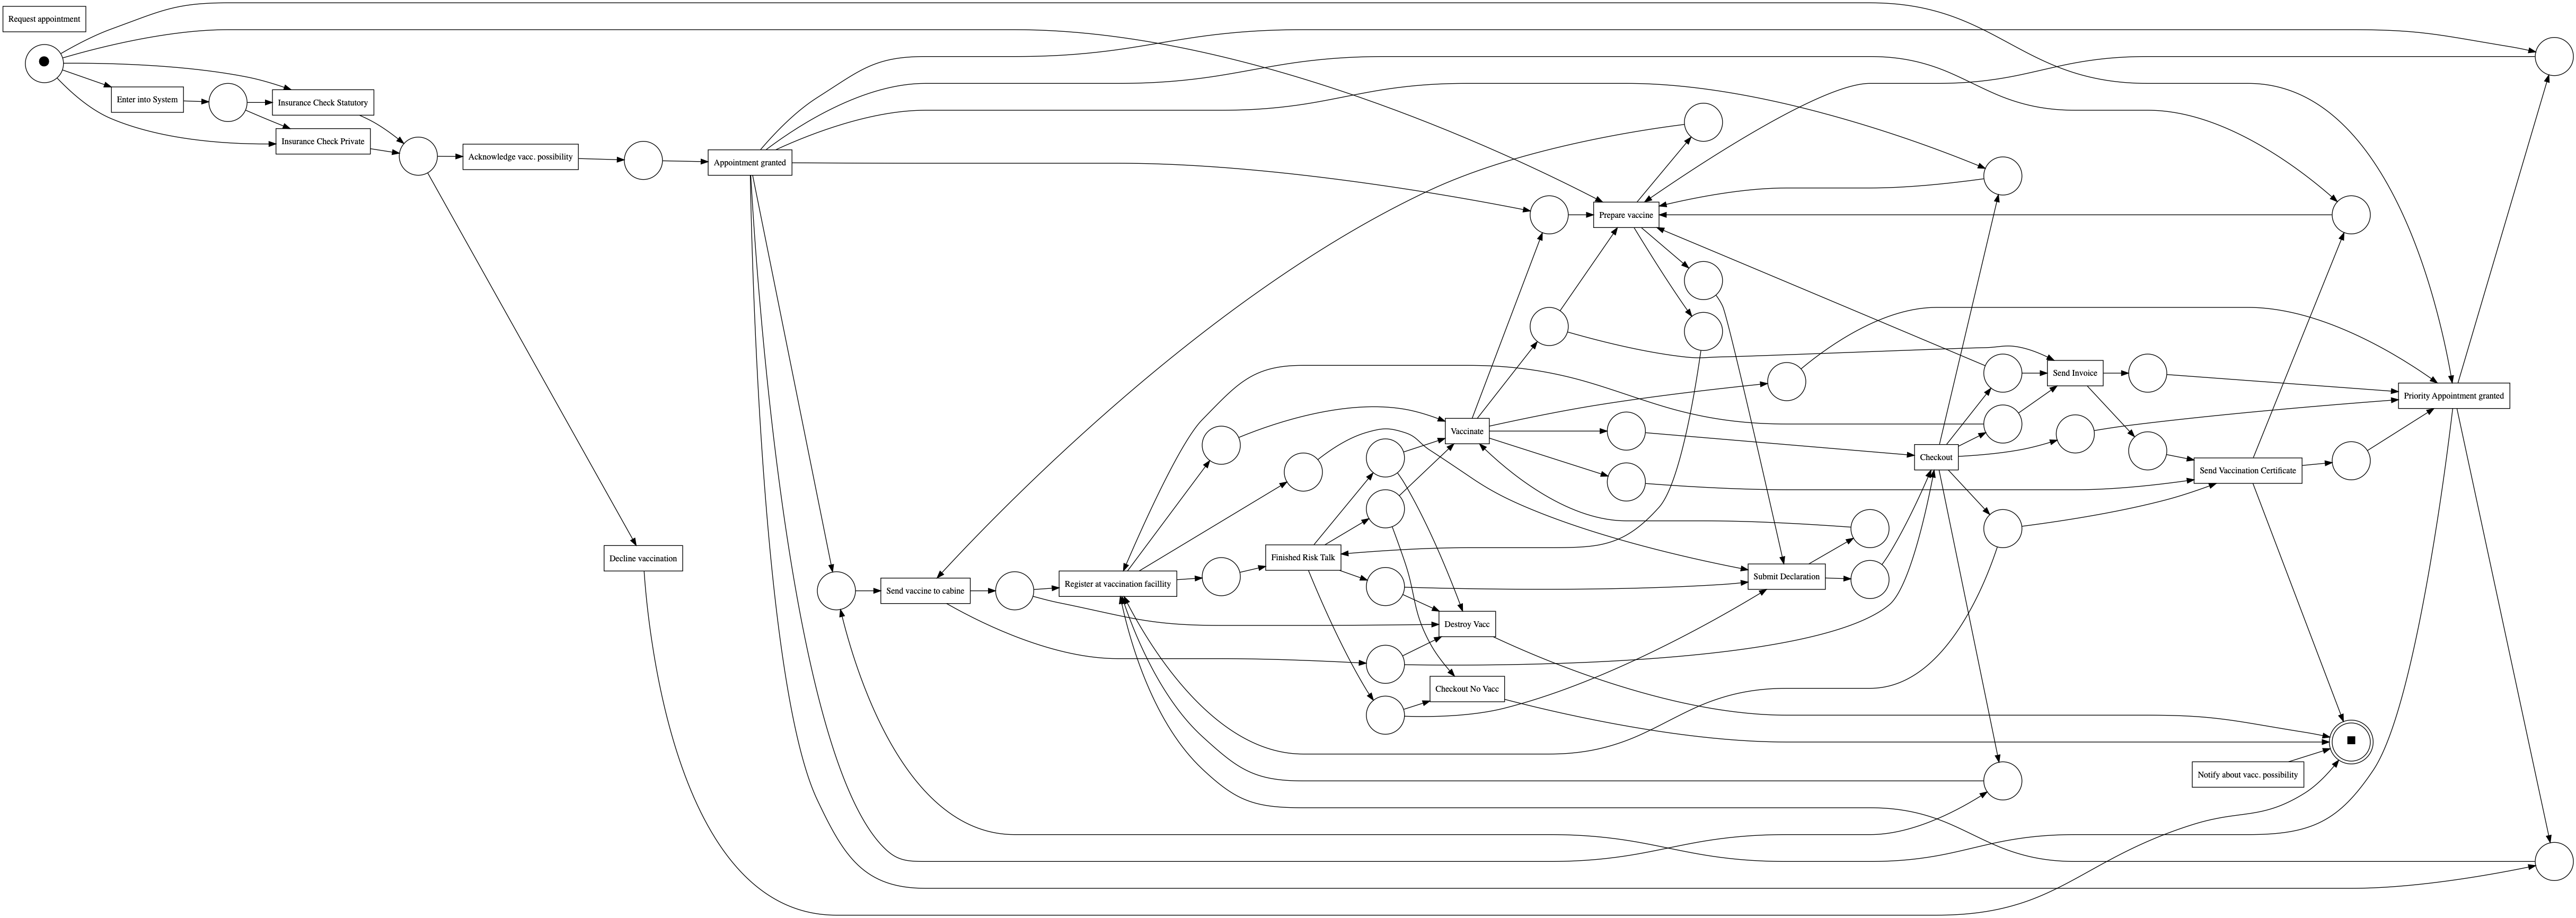

In [22]:
pt_visualizer.view(gviz_models['net_alpha'])

#### 4) ILP Miner

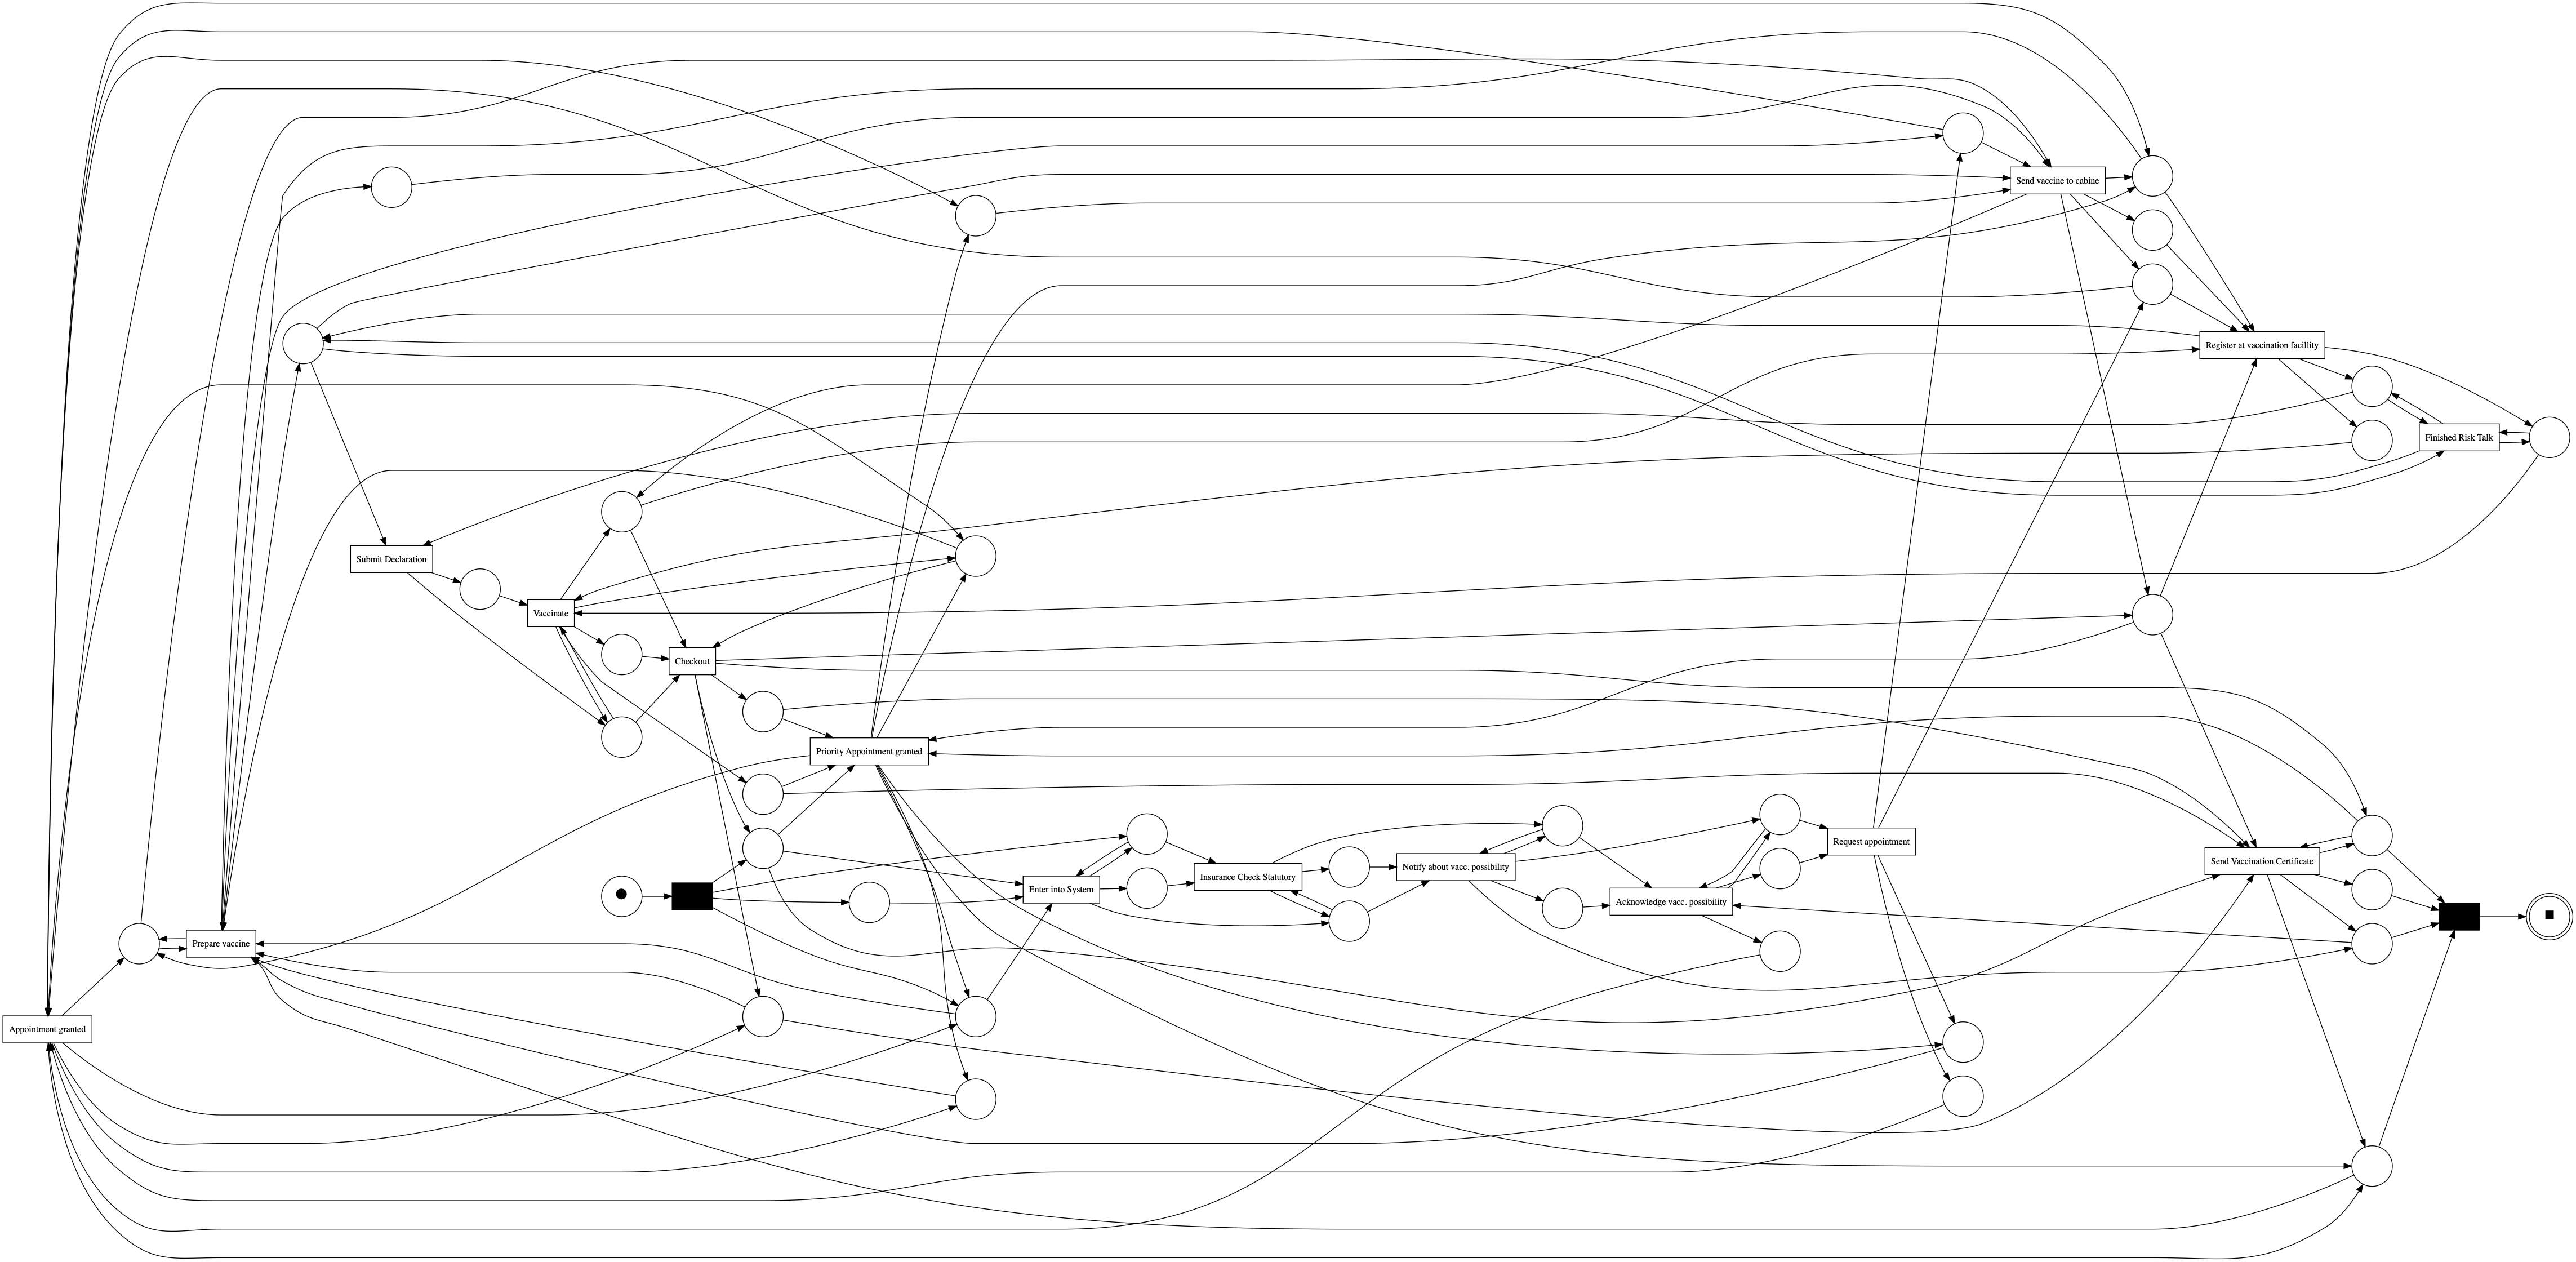

In [23]:
pt_visualizer.view(gviz_models['net_ilp'])

#### State Based Regions

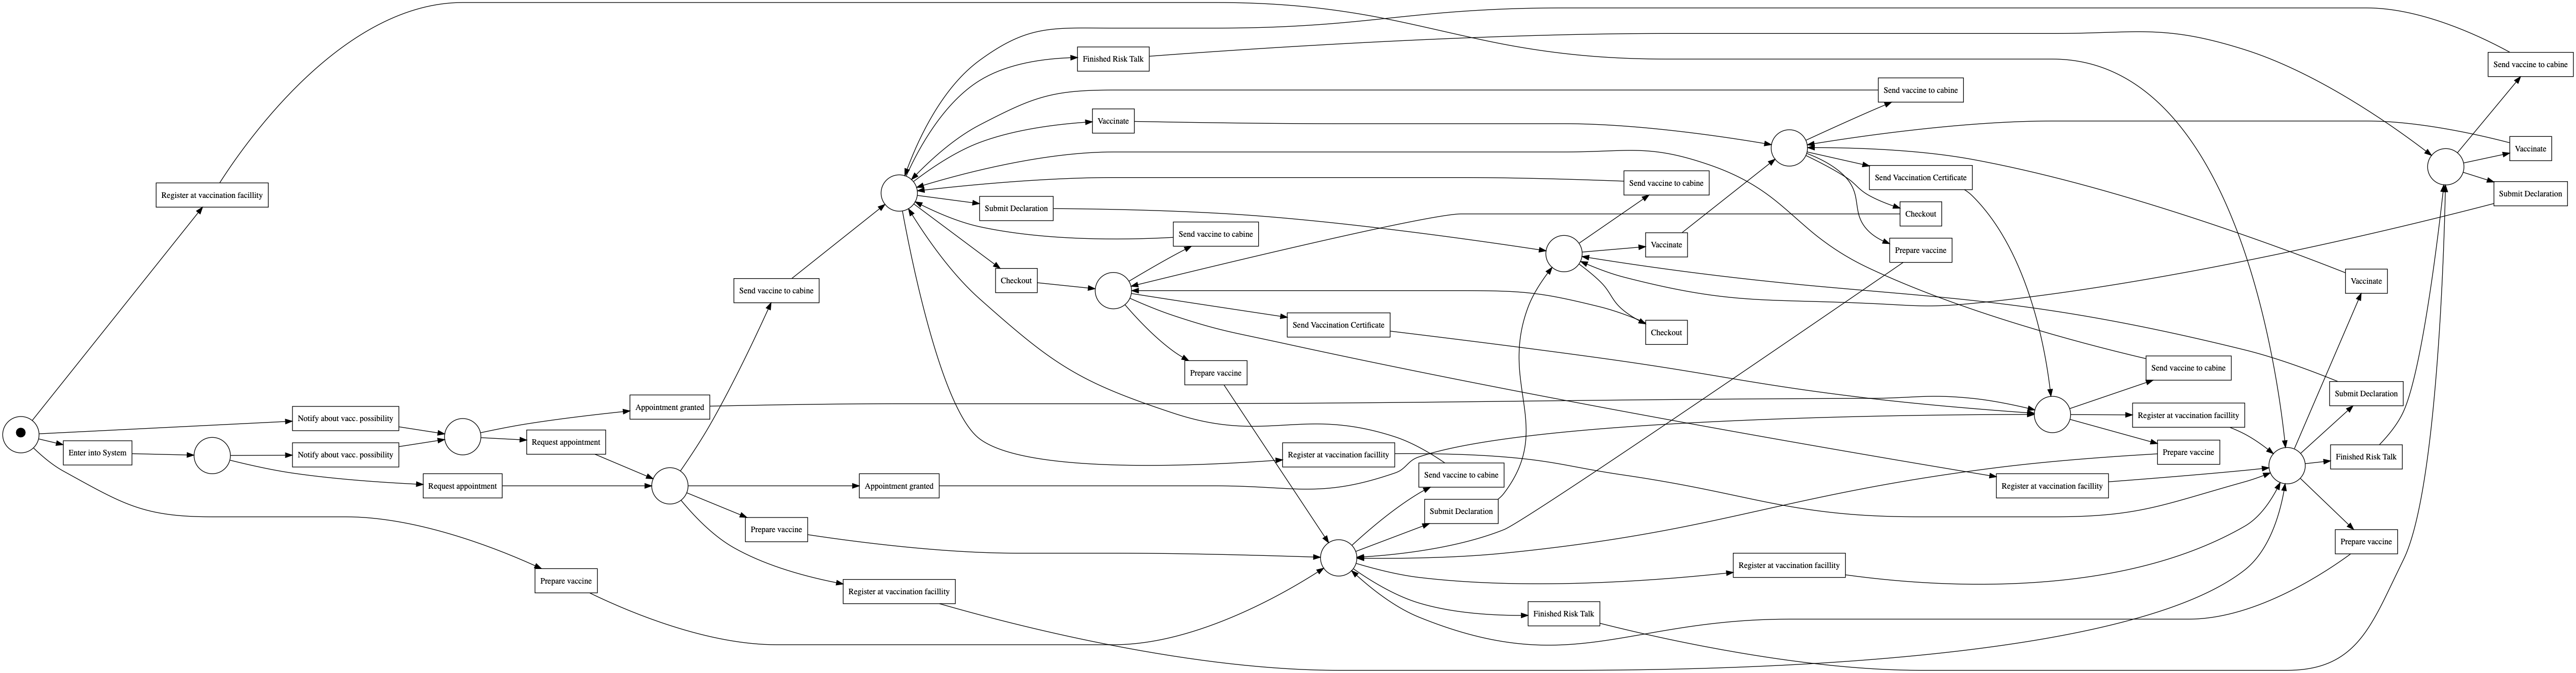

In [24]:
pt_visualizer.view(gviz_models['net_sr'])

In [25]:
# gviz_models['net_im'].render("Figures/Q2b/im")
# gviz_models['net_hm'].render("Figures/Q2b/hm")
# gviz_models['net_alpha'].render("Figures/Q2b/alpha")
# gviz_models['net_ilp'].render("Figures/Q2b/ilp")
# gviz_models['net_sr'].render("Figures/Q2b/sr")

### Model Evaluation

In [26]:
data

Model Fitness-Token Fitness-Alignment Precision-Token  \
0     Inductive Miner      0.965519          0.945467        0.919382   
1     Heuristic Miner      0.966809          0.828002        0.799438   
2         Alpha Miner      0.771429                -1        0.399455   
3           ILP Miner      0.962426          0.883531        0.910164   
4  State Region Miner      0.954761                -1        0.540627   

  Precision-Alignment Generalization Simplicity  
0              0.9201       0.937063   0.795918  
1            0.799438       0.932175   0.664596  
2                  -1       0.972661   0.398601  
3            0.937179       0.984557   0.268519  
4                  -1       0.881544   0.473684

## Question 2c

### Filter log so that it contains only activities from patients perspective

In [27]:
from pm4py.algo.filtering.log.start_activities import start_activities_filter
#remove traces where Notify about vacc. possibility is directly followed by itself
filtered_log = pm4py.filter_directly_follows_relation(finished_log, [('Notify about vacc. possibility', 'Notify about vacc. possibility')], retain=False)

#remove traces that do not start with "Enter into System" activity
filtered_log = start_activities_filter.apply(filtered_log, ["Enter into System"])

#remove the activites in the list
activities_to_remove = ['Insurance Check Private', 
                        'Insurance Check Statutory', 
                        'Prepare vaccine', 
                        'Send vaccine to cabine', 
                        'Send Vaccination Certificate',
                        'Appointment granted', 
                        'Priority Appointment granted',
                        'Destroy Vacc',
                        'Send Invoice'
                        ]
for act in activities_to_remove:
    filtered_log = pm4py.filter_event_attribute_values(filtered_log, 'concept:name', act, level='event', retain=False)

event_numb = 0
#rename the activity 'Checkout No Vacc' to 'Decline vaccination'
for i in range(len(filtered_log)): #iterate over each case
    for j in range(len(filtered_log[i])): #eiterate on every event corresponding to the case
        event_numb += 1
        if filtered_log[i][j]['concept:name'] == 'Checkout No Vacc':
            filtered_log[i][j]['concept:name'] = 'Decline vaccination'


In [28]:
#report the different activities and no. of cases & events
activities = get_event_labels(filtered_log, key='concept:name')
print(f'Number of cases: {len(filtered_log)}\nNumber of events: {event_numb}')
print("Activities in the filtered log:")
get_event_labels_counted(filtered_log, key='concept:name')

Number of cases: 3316
Number of events: 37761
Activities in the filtered log:


{'Enter into System': 3316,
 'Notify about vacc. possibility': 3270,
 'Acknowledge vacc. possibility': 2820,
 'Request appointment': 3130,
 'Register at vaccination facillity': 5507,
 'Finished Risk Talk': 2825,
 'Submit Declaration': 5447,
 'Vaccinate': 5450,
 'Checkout': 5455,
 'Decline vaccination': 541}

## Question 2d

In [29]:
#import log
log_2c = pm4py.read_xes(os.path.join(LOG_ROOT, "log_vaccination_2c.xes"))

parsing log, completed traces :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3316/3316 [00:02<00:00, 1655.18it/s]


In [30]:
# #print number of activities and cases to compare to the filtered event log from above
# activities = get_event_labels(log_2c, key='concept:name')
# print(f'Activities: {activities}\nNumber of cases: {len(log_2c)}')

In [39]:
# net_shand, im_shand, fm_shand = pnml_importer.apply(os.path.join(MODELS_FOLDER,"small_hand.pnml"))
# gviz = pn_visualizer.apply(net_shand, im_shand, fm_shand)
# pn_visualizer.view(gviz)

### Discover models on filtered log (Patients perspective)

In [32]:
net_list = [('Inductive Miner', 'net_im'), ('Heuristic Miner', 'net_hm'), ('Alpha Miner', 'net_alpha'), ('ILP Miner', 'net_ilp'), ('State Region Miner', 'net_sr'), ('Handdrawn Model', 'small_hand')]
data_2d, gviz_models_2d = discover_models_and_qualities(log_2c, "2d", net_list)

Model discovered by Inductive Miner: 


replaying log with TBR, completed variants :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:00<00:00, 2706.66it/s]
computing precision with alignments, completed variants :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:00<00:00, 749.27it/s]
replaying log with TBR, completed variants :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 793.38it/s]


Model discovered by Heuristic Miner: 


replaying log with TBR, completed variants :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 545.23it/s]


Model discovered by Alpha Miner: 


replaying log with TBR, completed variants :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 876.35it/s]


Model discovered by ILP Miner: 


replaying log with TBR, completed variants :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:00<00:00, 2068.60it/s]
computing precision with alignments, completed variants :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:00<00:00, 345.15it/s]
replaying log with TBR, completed variants :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 736.14it/s]


Model discovered by State Region Miner: 


replaying log with TBR, completed variants :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 846.76it/s]


Model discovered by Handdrawn Model: 


replaying log with TBR, completed variants :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:00<00:00, 1425.91it/s]
computing precision with alignments, completed variants :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:00<00:00, 607.76it/s]
replaying log with TBR, completed variants :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 724.65it/s]


### Display Models

#### 1) Inductive Miner

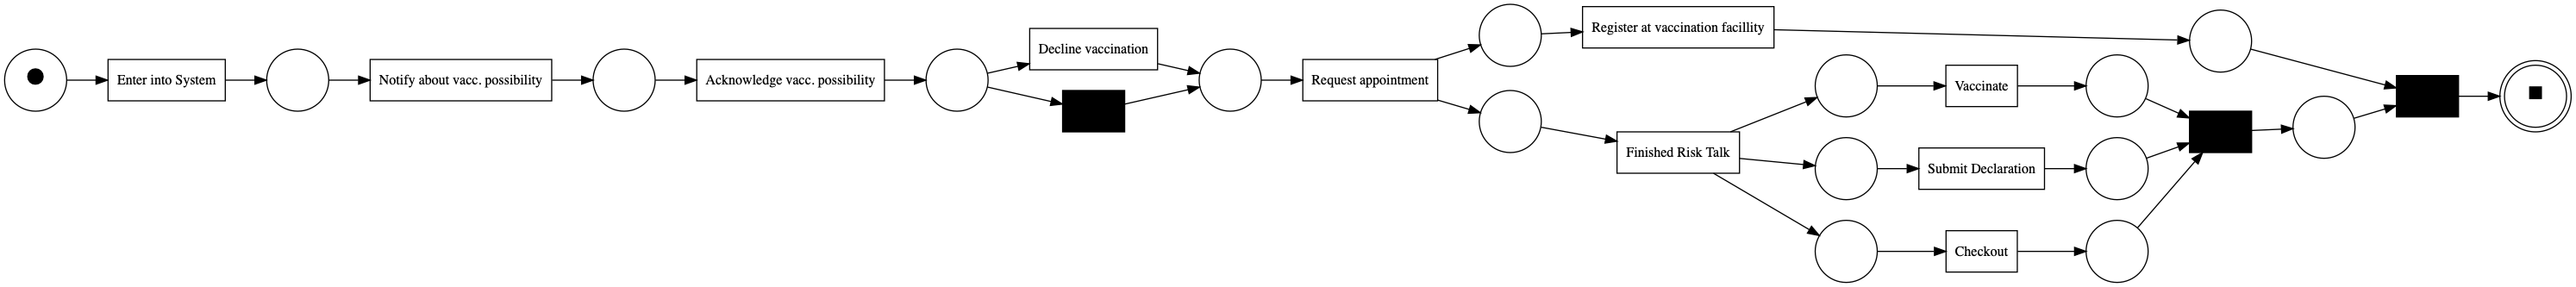

In [33]:
pt_visualizer.view(gviz_models_2d['net_im'])

#### 2) Heuristic Miner

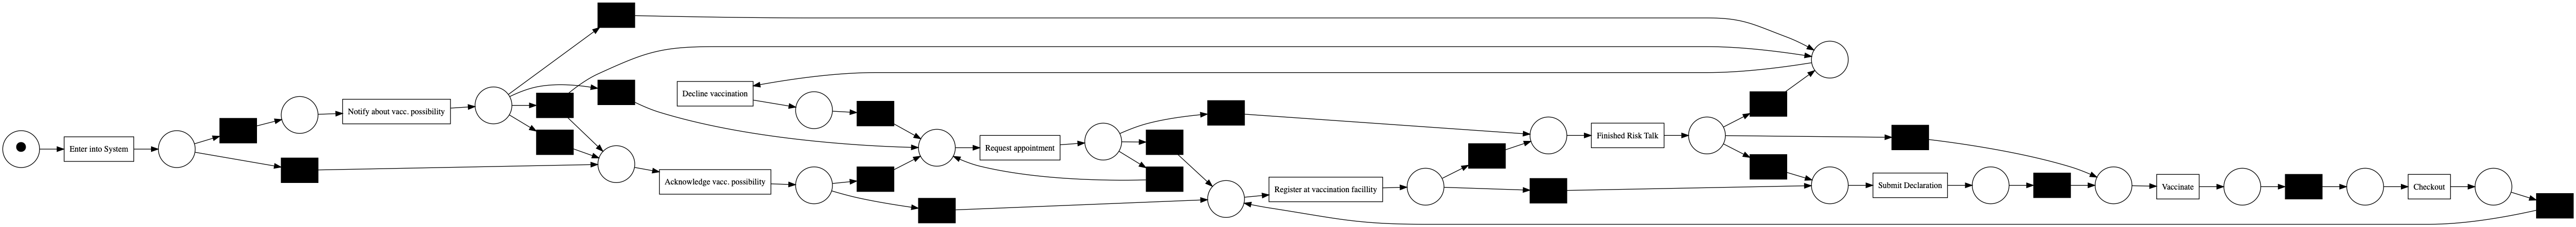

In [34]:
pt_visualizer.view(gviz_models_2d['net_hm'])

#### 3) Alpha Miner

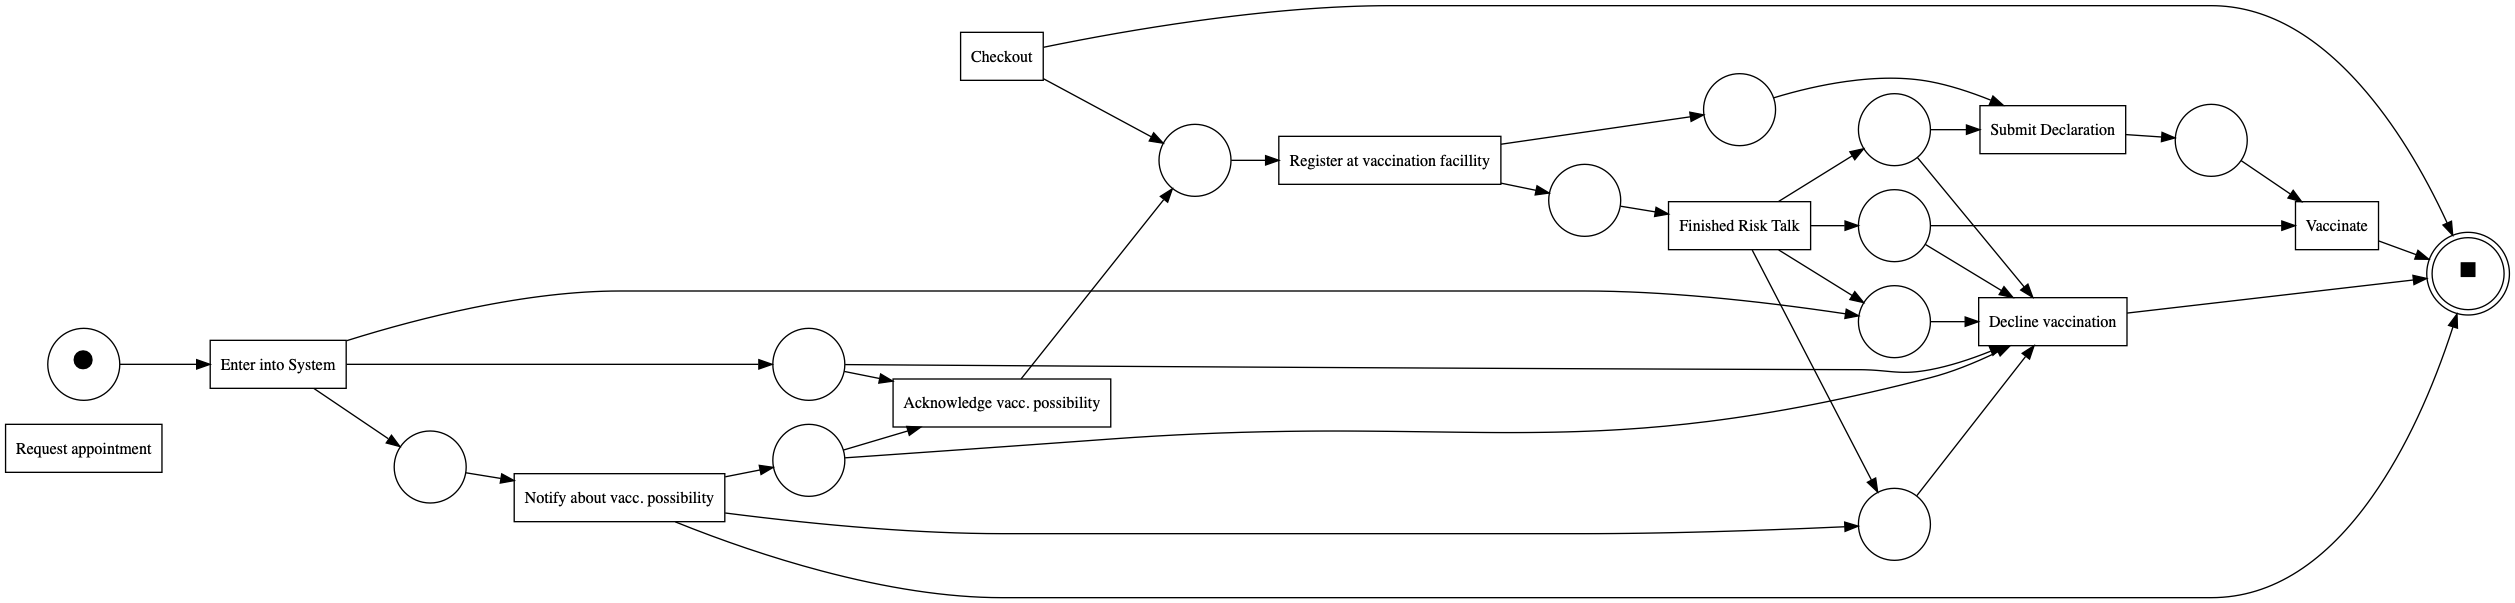

In [35]:
pt_visualizer.view(gviz_models_2d['net_alpha'])

#### 4) ILP

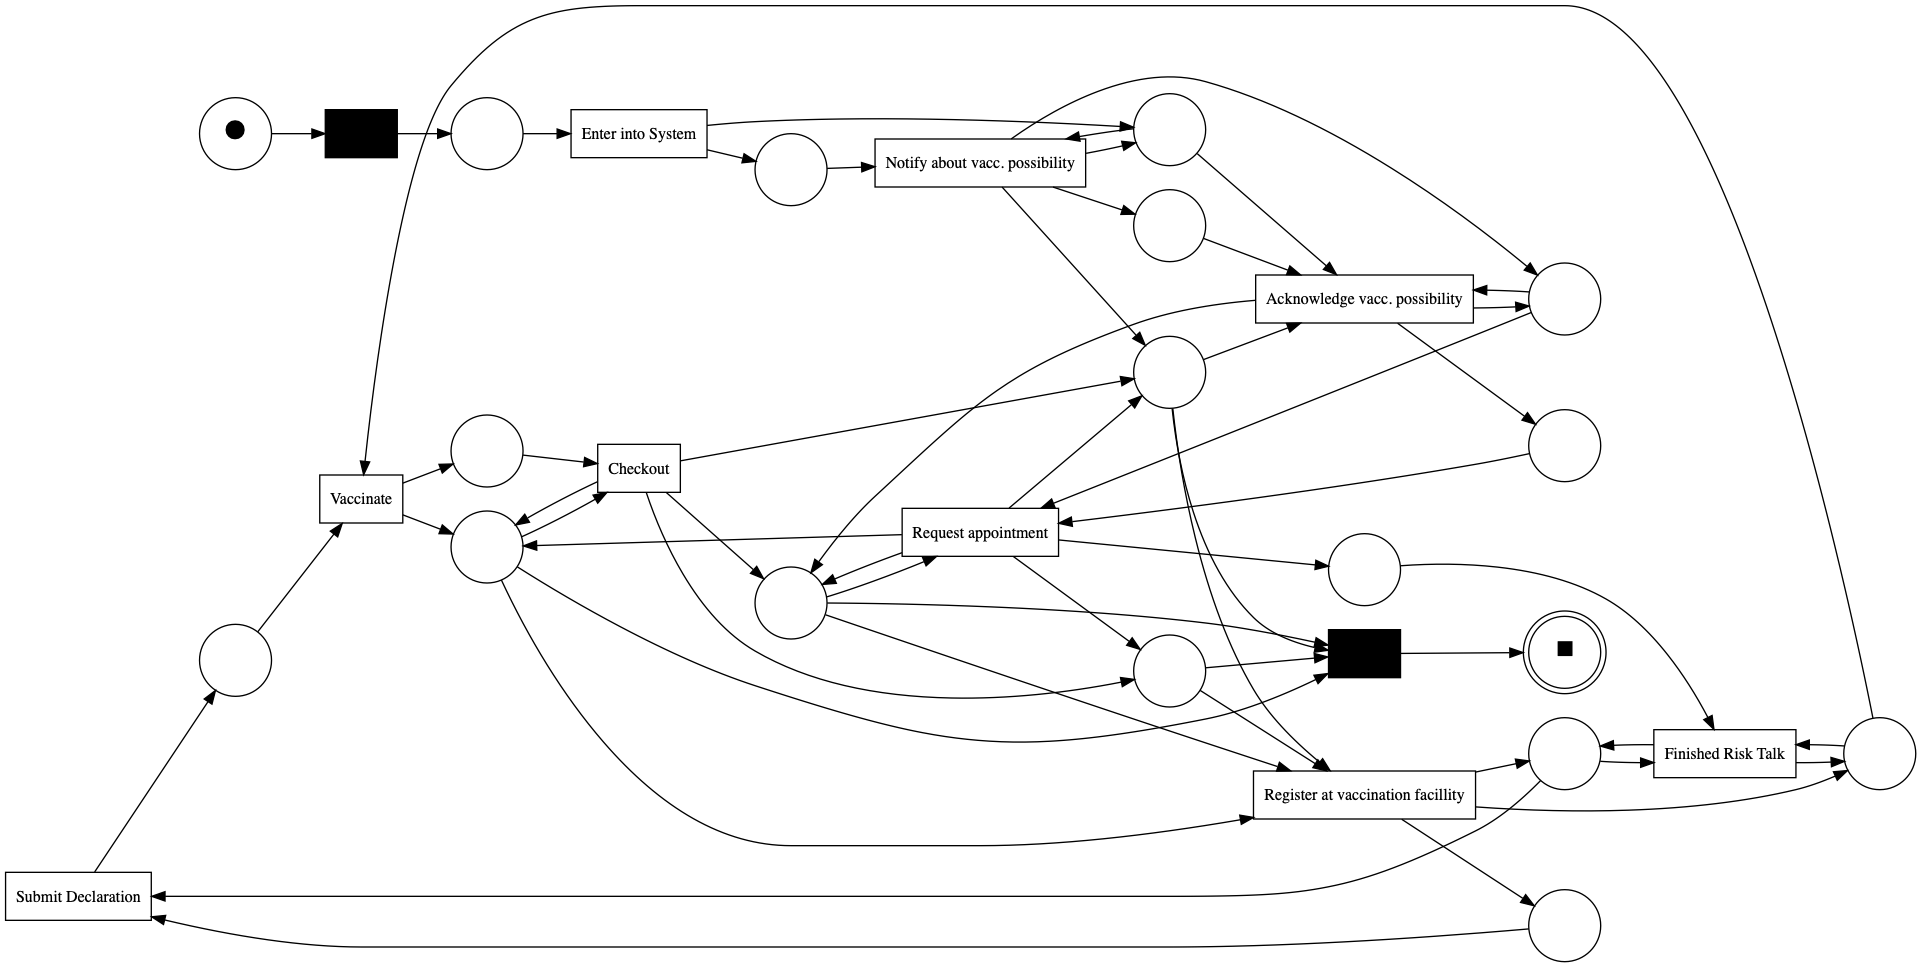

In [36]:
pt_visualizer.view(gviz_models_2d['net_ilp'])


#### 5) State-based Regions

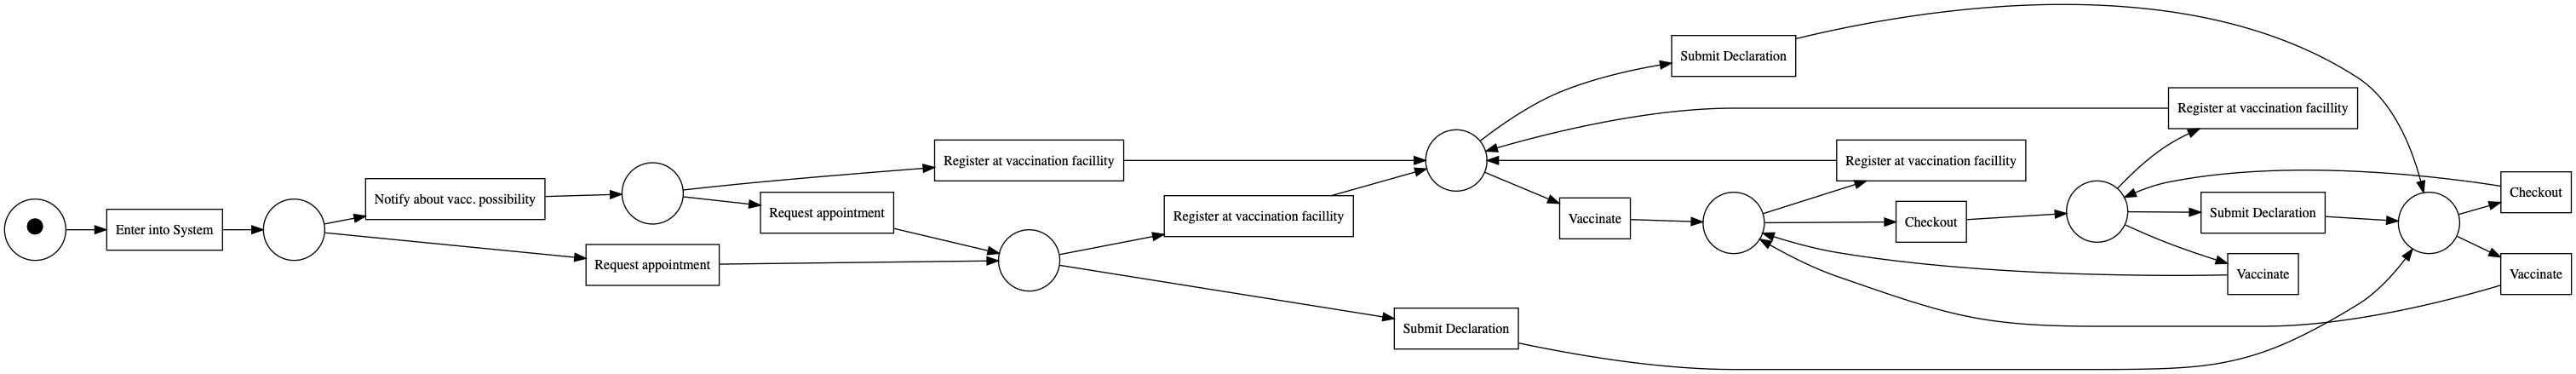

In [37]:
pt_visualizer.view(gviz_models_2d['net_sr'])

### Small Hand Model

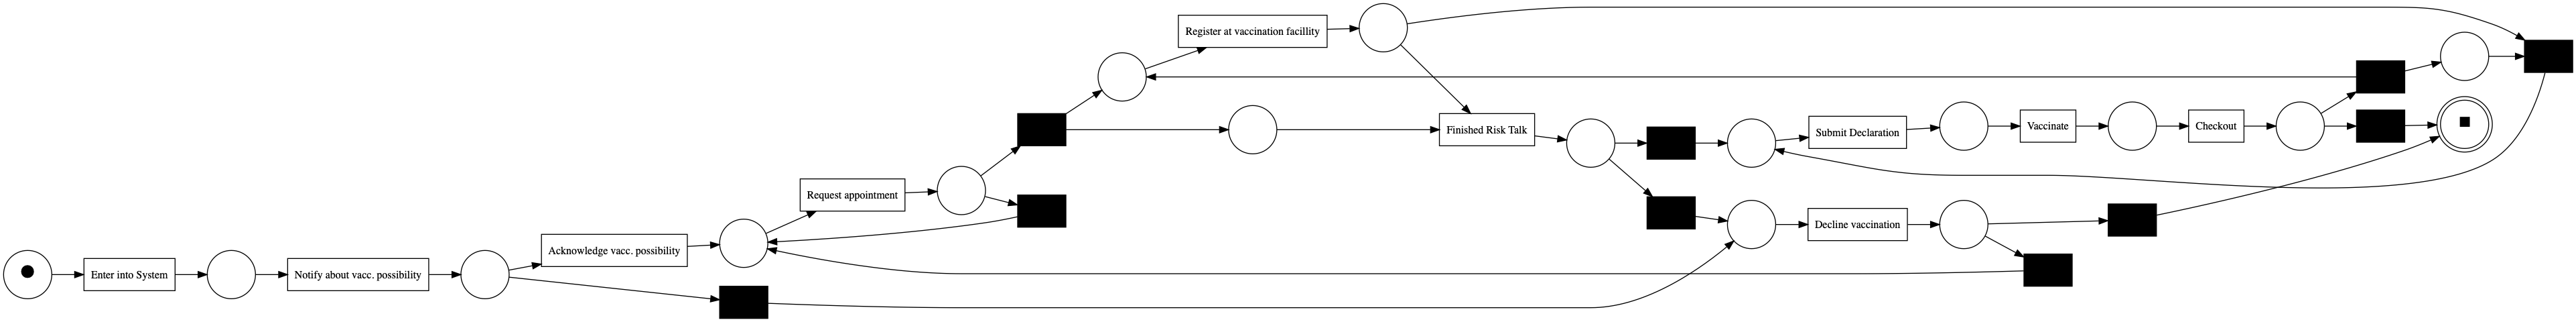

In [41]:
#pt_visualizer.view(gviz_models_2d['small_hand'])
net_shand, im_shand, fm_shand = pnml_importer.apply(os.path.join(MODELS_FOLDER,"small_hand.pnml"))
gviz = pn_visualizer.apply(net_shand, im_shand, fm_shand)
pn_visualizer.view(gviz)

In [42]:
# gviz_models_2d['net_im'].render("Figures/Q2d/im")
# gviz_models_2d['net_hm'].render("Figures/Q2d/hm")
# gviz_models_2d['net_alpha'].render("Figures/Q2d/alpha")
# gviz_models_2d['net_ilp'].render("Figures/Q2d/ilp")
# gviz_models_2d['net_sr'].render("Figures/Q2d/sr")
# gviz_models_2d['small_hand'].render("Figures/Q2d/shand")

### Model Evaluation

In [43]:
data_2d

Model Fitness-Token Fitness-Alignment Precision-Token  \
0     Inductive Miner      0.785323          0.783289        0.855878   
1     Heuristic Miner        0.9763                -1        0.947605   
2         Alpha Miner      0.729886                -1        0.448487   
3           ILP Miner      0.974238           0.93152        0.998993   
4  State Region Miner      0.943431                -1          0.8382   
5     Handdrawn Model      0.993368          0.992904        0.996637   

  Precision-Alignment Generalization Simplicity  
0            0.855878       0.981198   0.828571  
1                  -1       0.907697   0.694444  
2                  -1       0.981252   0.511111  
3            0.999364       0.983559   0.349398  
4                  -1       0.863613        0.6  
5            0.996637       0.959157    0.72549

In [44]:
# events_following_decline = []
# num_decline = 0
# second_vacc = 0
# t = 0
# num_following_decline = 0
# for trace in log_2c:
#     t = t+1
#     for i,event in enumerate(trace):
#         if event['concept:name'] == 'Checkout':
#             num_decline = num_decline +1
#             try:
#                 events_following_decline.append(trace[i+1]['concept:name'])
#                 if(trace[i+1]['concept:name'] == 'Register at vaccination facillity'):
#                     second_vacc = second_vacc +1
#                 num_following_decline = num_following_decline+1
#             except IndexError:
#                 pass
# print(set(events_following_decline))
# print("Numer of Checkout: {}".format(num_decline))
# print("Numer of cases with activities following Checkout: {}".format(num_following_decline))
# print("Numer of Second vaccinations: {}".format(second_vacc))

# print(t)

## Question 2e

In [45]:
#import log
thresholds = [0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 1]
data = pd.DataFrame(columns=['Threshold','Fitness', 'Precision', 'Generalization', 'Simplicity'])

for t in thresholds:
    net, im, fm =  pm4py.discover_petri_net_inductive(log_2c, t)
    fitness_tb = replay_fitness_evaluator.apply(log_2c, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
    prec_tb = precision_evaluator.apply(log_2c, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
    gen = generalization_evaluator.apply(log_2c, net, im, fm)
    simp = simplicity_evaluator.apply(net)
    df = pd.DataFrame([[t, fitness_tb['log_fitness'], prec_tb, gen, simp]], columns=['Threshold', 'Fitness', 'Precision', 'Generalization', 'Simplicity'])    
    data = pd.concat([data,df], ignore_index=True)
data

replaying log with TBR, completed variants :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 741.32it/s]


Threshold   Fitness Precision Generalization Simplicity
0         0       1.0  0.340601        0.94145   0.657143
1       0.2  0.989565  0.824171       0.974026   0.777778
2       0.4  0.989565  0.824171       0.974026   0.777778
3       0.6  0.938293  0.935389       0.964335   0.837838
4       0.7  0.938293  0.935389       0.964335   0.837838
5       0.8  0.938293  0.935389       0.964335   0.837838
6       0.9  0.938293  0.935389       0.964335   0.837838
7      0.95  0.938293  0.935389       0.964335   0.837838
8         1  0.938293  0.935389       0.964335   0.837838

# Question 3: Conformance Checking

## Question 3a

parsing log, completed traces :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3978/3978 [00:03<00:00, 1098.28it/s]


Handwritten Model - Inductive Miner:


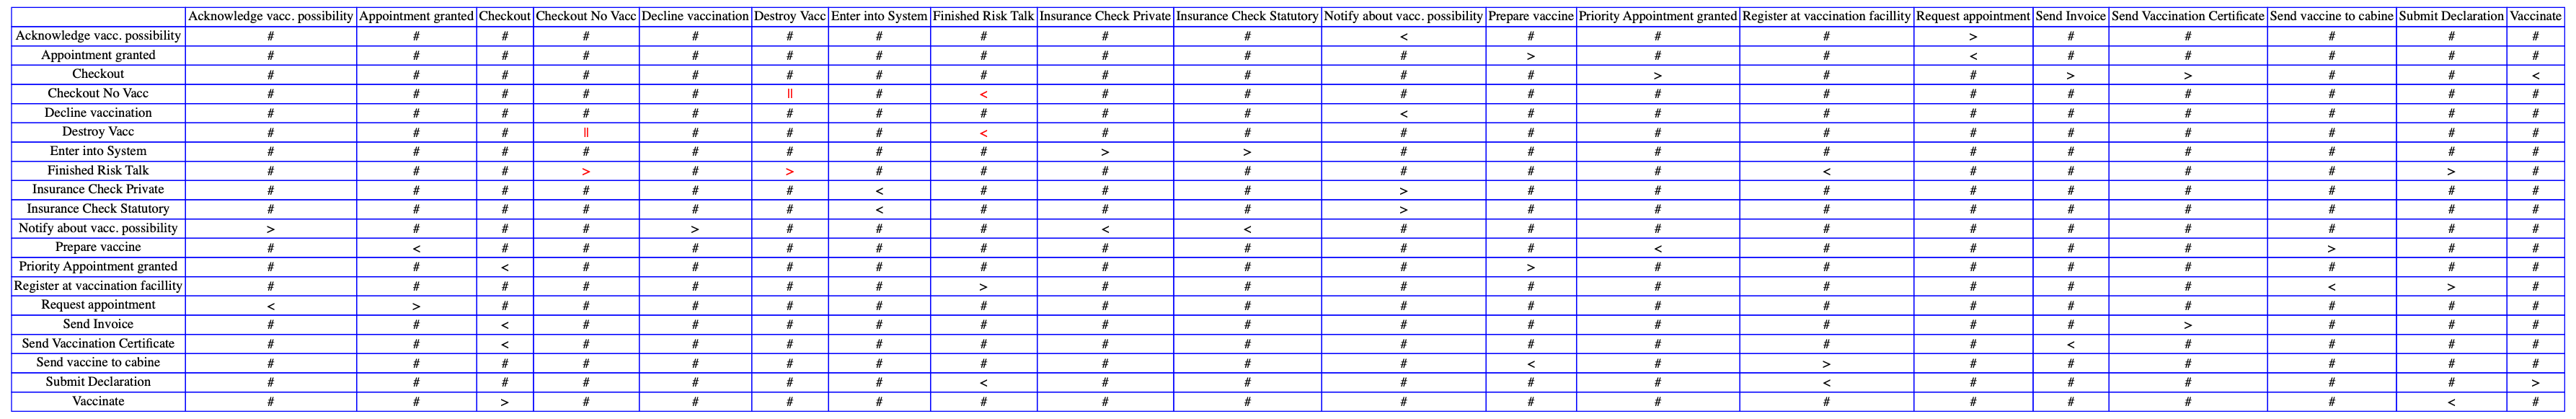

Inductive Miner - Handwritten Model:


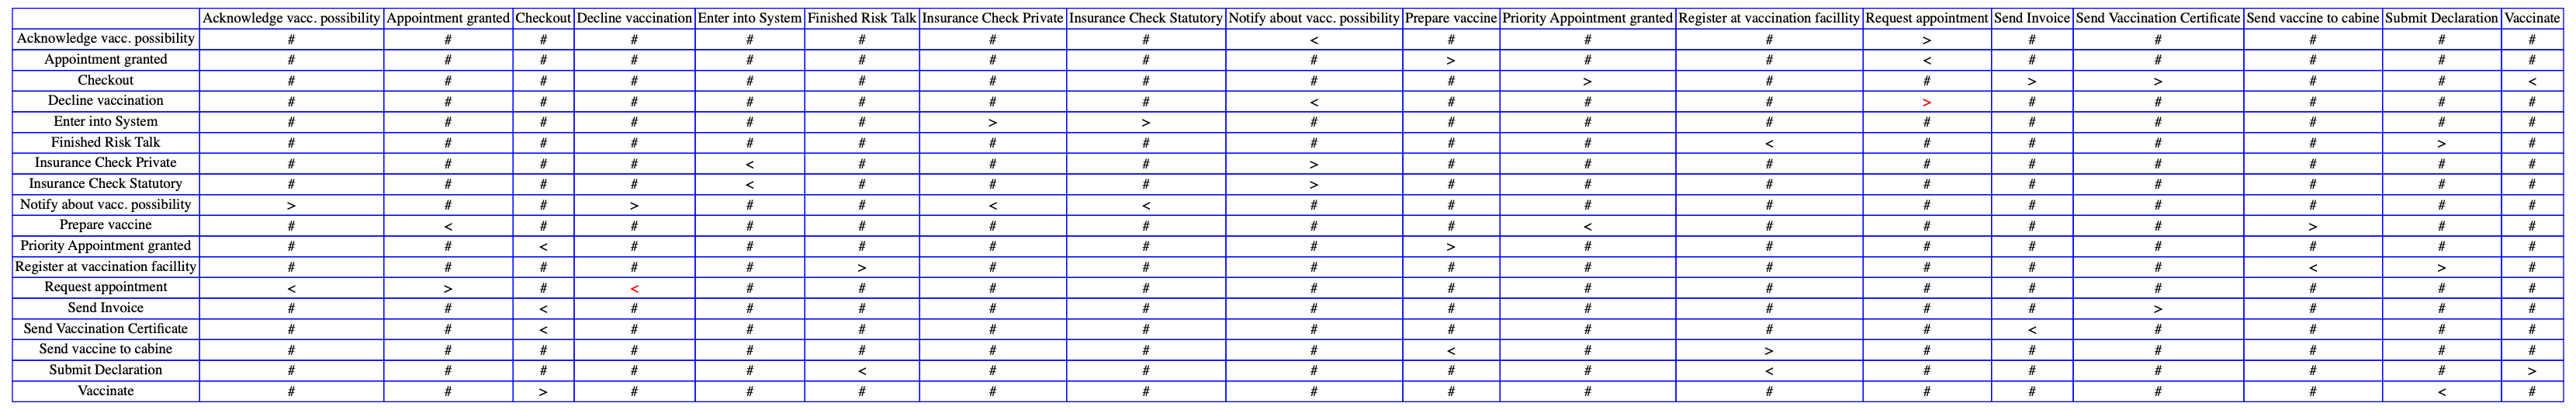

Handwritten Model - Heuristic Miner: 



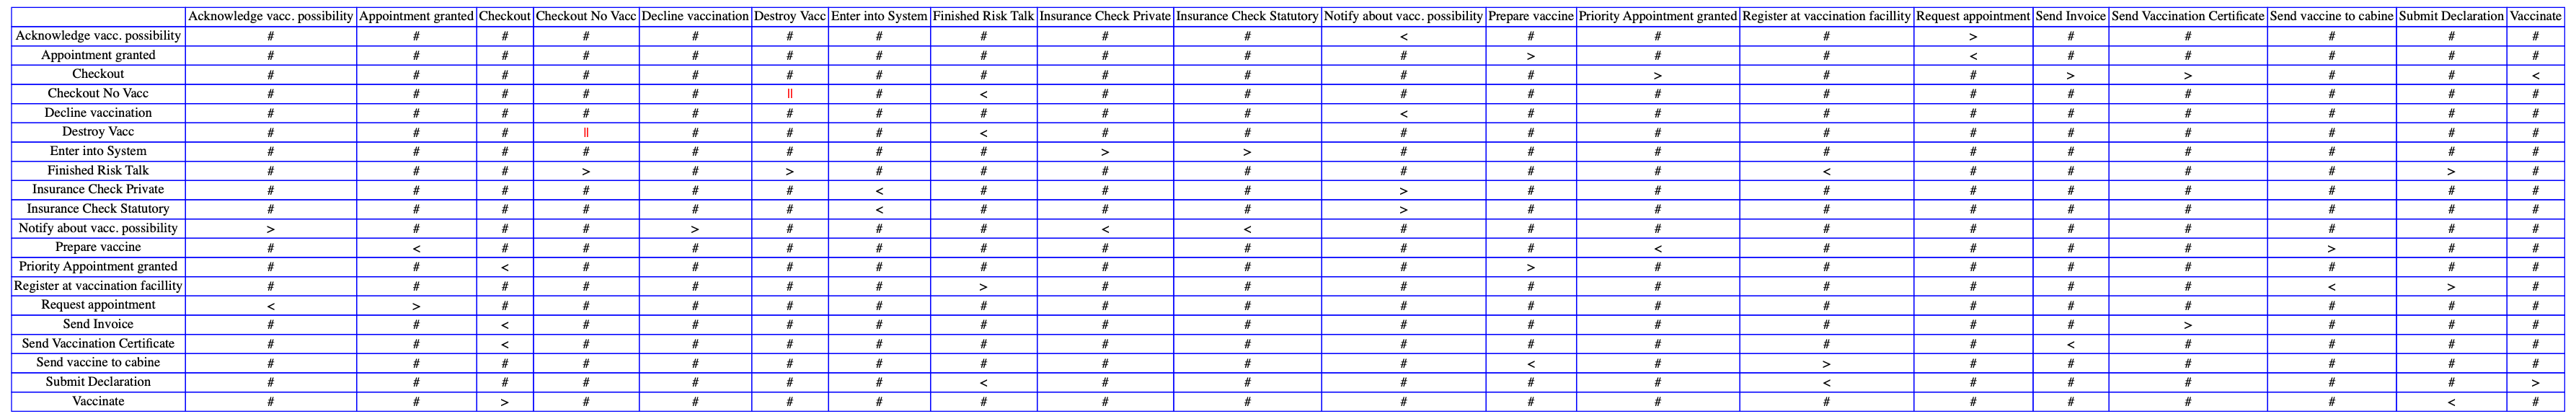

Heuristic Miner - Handwritten Model: 



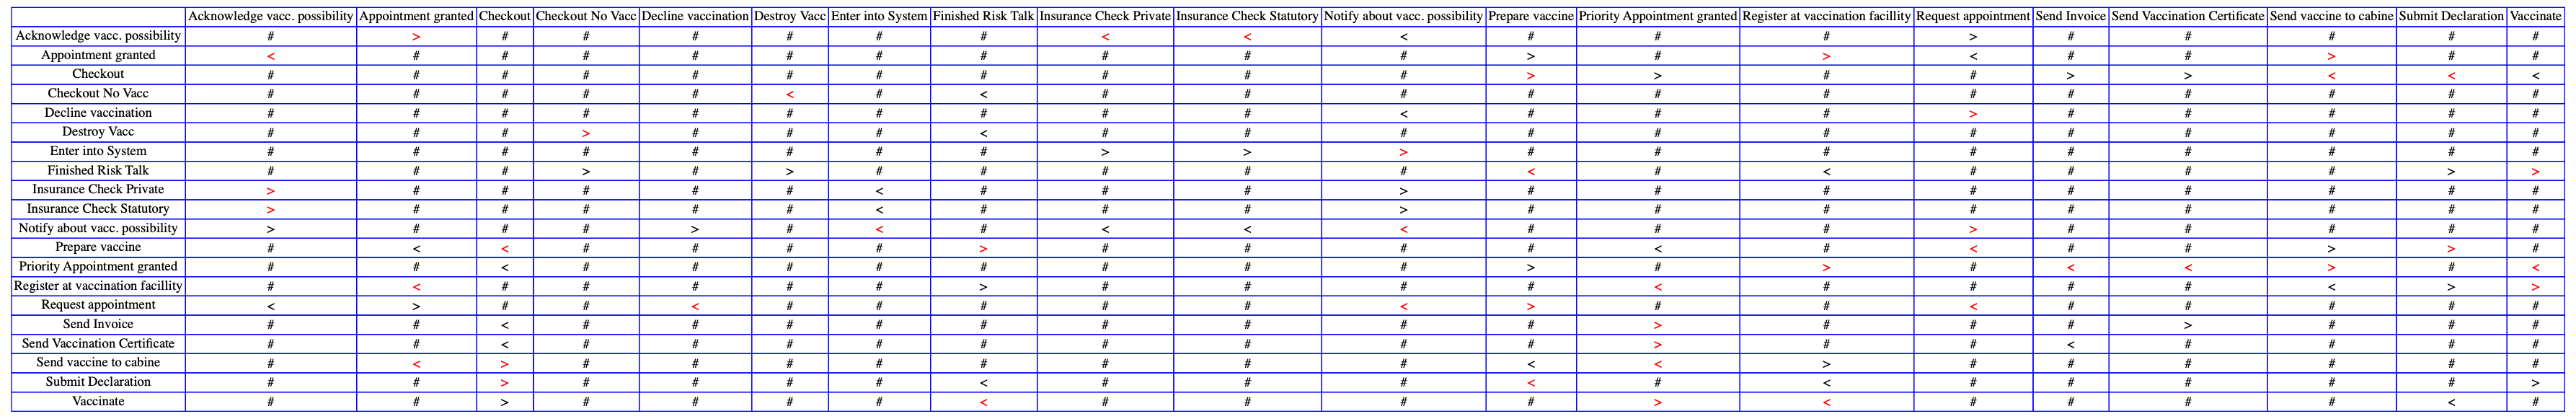

In [46]:
#load the log for the finished cases
finished_log = pm4py.read_xes(os.path.join(LOG_ROOT, "log_vaccination_finished_cases.xes"))

#calculate the footprint of entire log
fp_log = footprints_discovery.apply(finished_log, variant=footprints_discovery.Variants.ENTIRE_EVENT_LOG)

#Petri net discovered using Inductive Miner (Task 2b)
net_im, im1, fm1 =  pnml_importer.apply(os.path.join(MODELS_FOLDER, "2b", "net_im.pnml"))
#compute the footprint for the model found by inductive miner 
fp_net_im =  footprints_discovery.apply(net_im, im1, fm1)

#Petri net discovered using Heuristic Miner (Task 2b)
net_hm, im2, fm2 =  pnml_importer.apply(os.path.join(MODELS_FOLDER, "2b", "net_hm.pnml")) 
#compute the footprint for the model found by heuristic miner 
fp_net_hm = footprints_discovery.apply(net_hm, im2, fm2)

#handwritten model
net_m, im3, fm3 = pnml_importer.apply(os.path.join(MODELS_FOLDER,"full_hand.pnml"))
#compute the footprint matrix for the handwritten model
fp_net_m = footprints_discovery.apply(net_m, im3, fm3)


#compare the two footprint tables 
print(f'Handwritten Model - Inductive Miner:')
gviz = fp_visualizer.apply(fp_net_m, fp_net_im) 
fp_visualizer.view(gviz)

print(f'Inductive Miner - Handwritten Model:')
gviz = fp_visualizer.apply(fp_net_im, fp_net_m) 
fp_visualizer.view(gviz)

#compare the two footprint tables 
print(f'Handwritten Model - Heuristic Miner: \n')
gviz = fp_visualizer.apply(fp_net_m, fp_net_hm, parameters={fp_visualizer.Variants.COMPARISON.value.Parameters.FORMAT: "png"})
fp_visualizer.view(gviz)

print(f'Heuristic Miner - Handwritten Model: \n')
gviz = fp_visualizer.apply(fp_net_hm, fp_net_m, parameters={fp_visualizer.Variants.COMPARISON.value.Parameters.FORMAT: "png"})
fp_visualizer.view(gviz)

Compute C(L,M) as defined in the lecture to characterize how well the model conforms the log

In [47]:
import itertools

def compute_fitness(fp_log, fp_net):

    activities = get_event_labels(finished_log, key='concept:name')
    no_relation_log = [x for x in list(itertools.product(activities, activities)) if x not in fp_log["sequence"] and x not in fp_log["parallel"] and x not in [tuple(reversed(x)) for x in fp_log["sequence"]]]
    no_relation_net = [x for x in list(itertools.product(activities, activities)) if x not in fp_net["sequence"] and x not in fp_net["parallel"] and x not in [tuple(reversed(x)) for x in fp_net["sequence"]]]
    misfits = 0
    for x in fp_log["sequence"]:
       if x not in fp_net["sequence"]:
            misfits += 2 #increase with two as the conflict is contained only in one direction

    for x in fp_log["parallel"]:
        if x not in fp_net["parallel"]:
            misfits += 1 #increase the number of misfits with one since conflicts are contained in both direction
    for x in no_relation_log:
        if x not in no_relation_net:
            misfits += 1
    act_number = len(get_event_labels(finished_log, key='concept:name'))
    fitness = 1 - misfits/(act_number*act_number) #percentage of entries infp_log the footprint matrix that is the same in both cases
    return fitness

In [48]:
import pandas as pd
data = pd.DataFrame(columns=['Model', 'Conformance', 'Sequence constructs', 'Parallel constructs'])
model_list = [('Inductive Miner', fp_net_im), ('Heuristic Miner', fp_net_hm)]
for model in model_list:
    fitness = compute_fitness(fp_net_m, model[1])
    seq_constructs = len(model[1].get('sequence'))
    parallel_constructs = len(model[1].get('parallel'))
    df = pd.DataFrame([[model[0], fitness, seq_constructs*2, parallel_constructs]], columns=['Model','Conformance', 'Sequence constructs', 'Parallel constructs'])
    data = pd.concat([data,df], ignore_index=True)
data

Model Conformance Sequence constructs Parallel constructs
0  Inductive Miner        0.98                  44                   0
1  Heuristic Miner       0.885                  94                   0

In [49]:
#constructs in the footprint matrix of the log
seq_constructs = len(fp_net_m.get('sequence'))
parallel_constructs = len(fp_net_m.get('parallel'))
print(f'Parallel constructs: {parallel_constructs}\nSequence constructs: {seq_constructs*2}')

Parallel constructs: 2
Sequence constructs: 46


## Question 3b

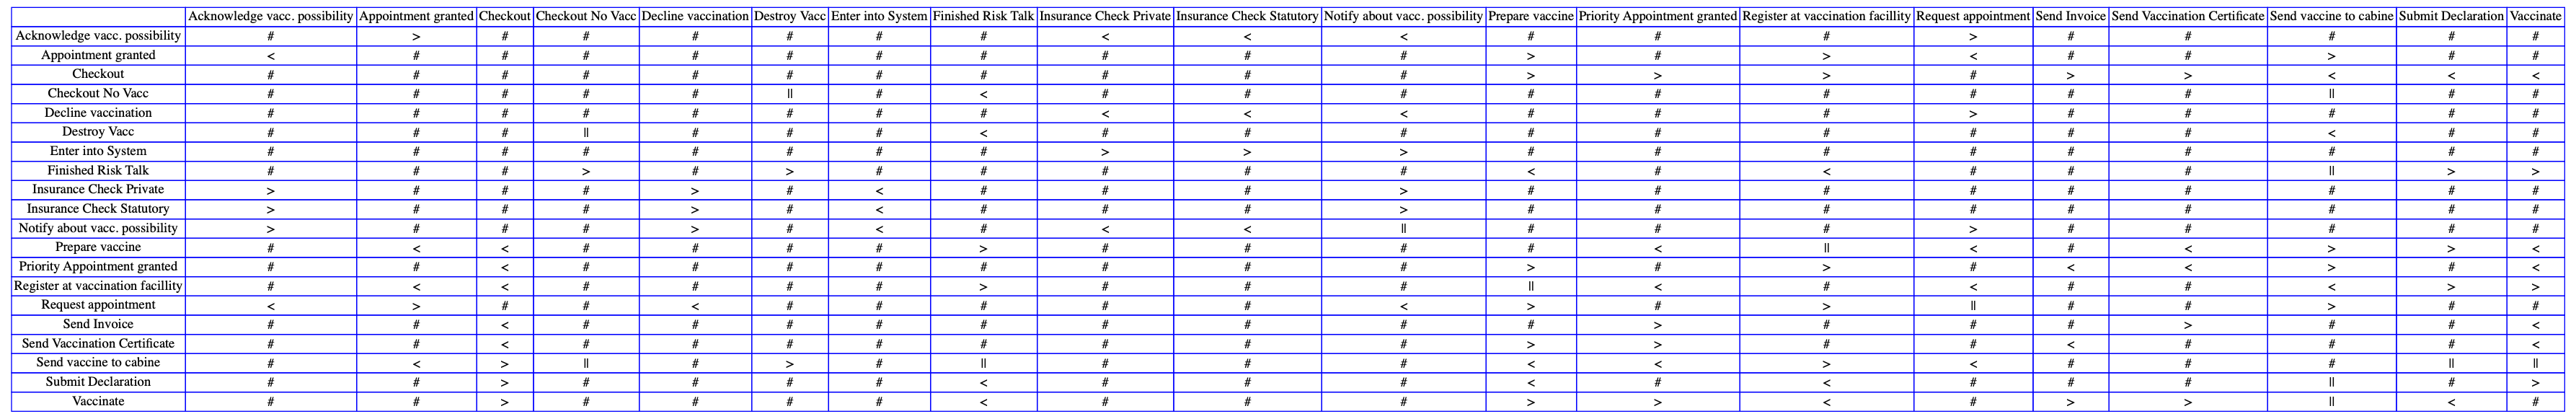

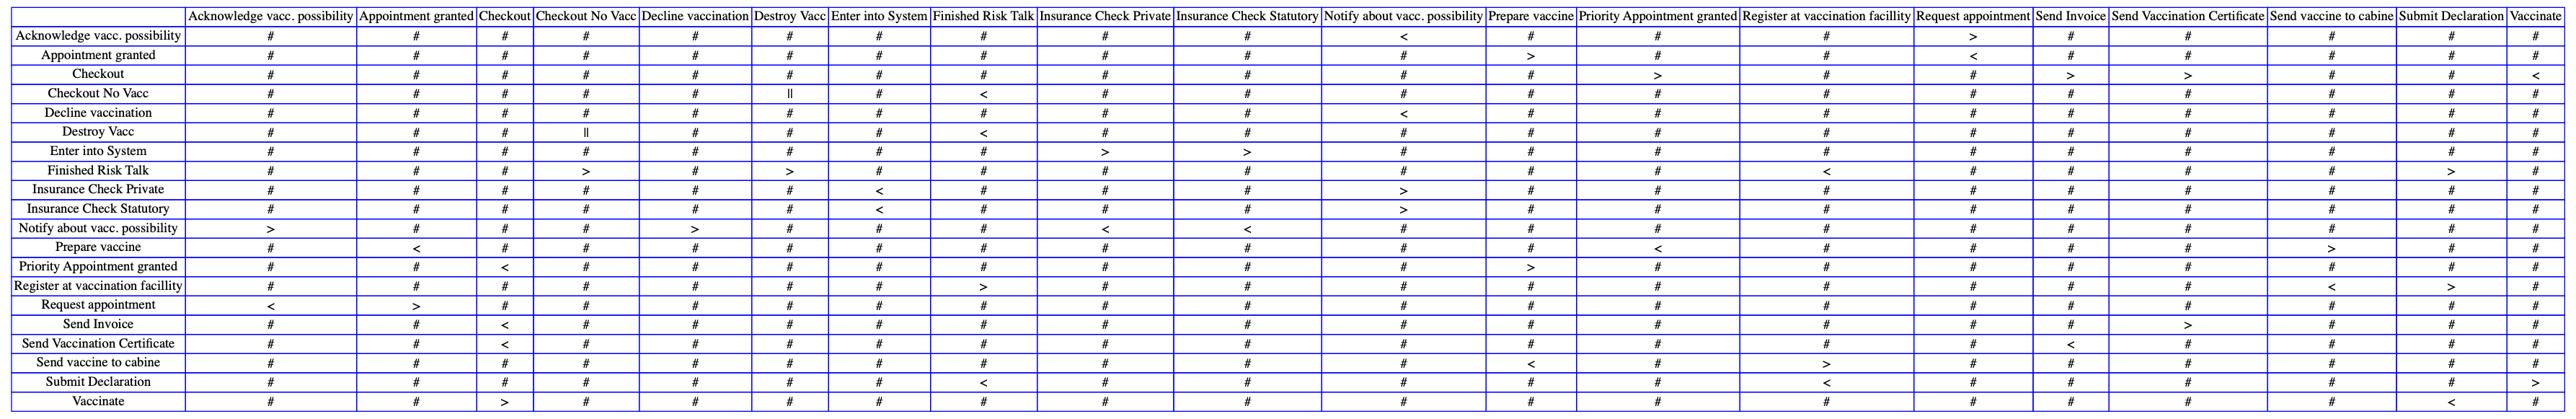

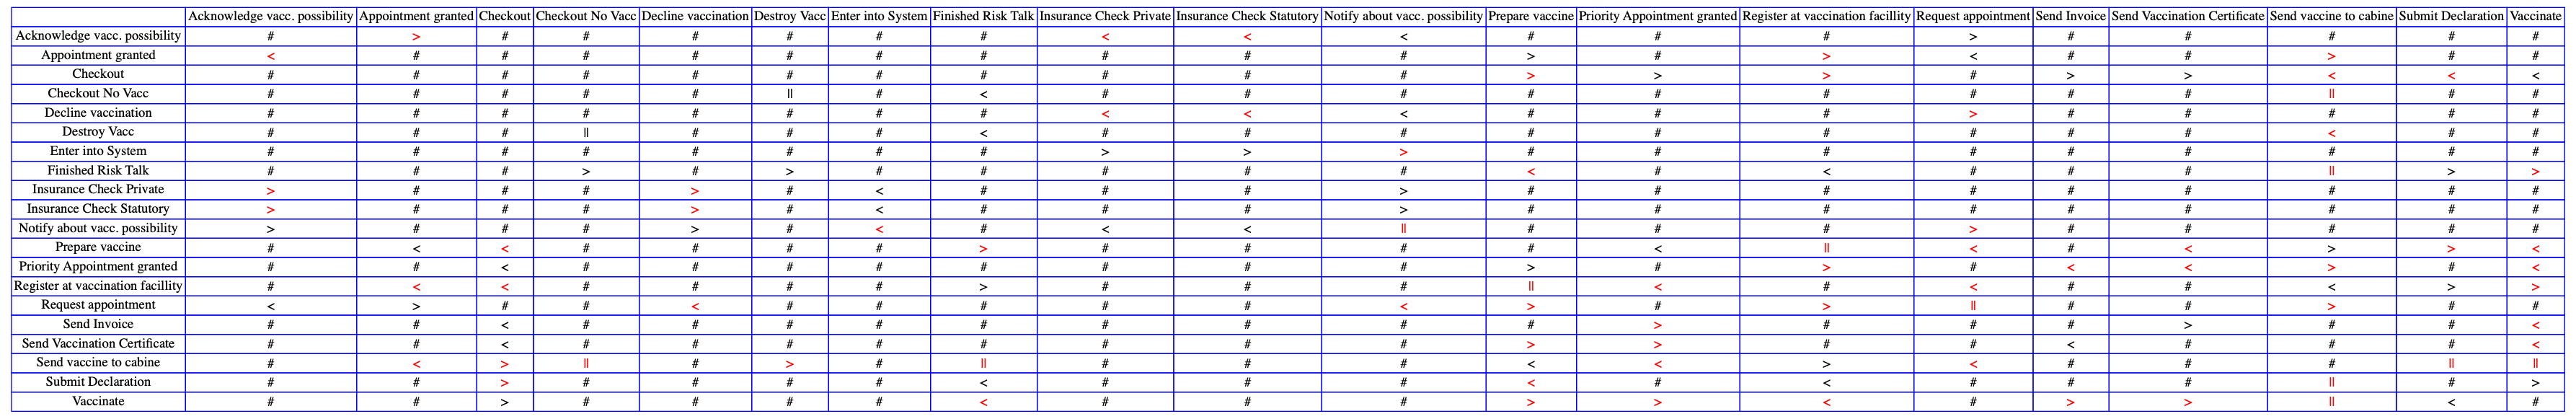

In [50]:
#import given model
net_m, im3, fm3 = pnml_importer.apply(os.path.join(MODELS_FOLDER,"full_hand.pnml"))
#compute the footprint matrix for the model
fp_net_m = footprints_discovery.apply(net_m, im3, fm3)

#visualize the footprint matrices to find any relevant patterns for the analysis
gviz = fp_visualizer.apply(fp_log, parameters={fp_visualizer.Variants.SINGLE.value.Parameters.FORMAT: "png"})
fp_visualizer.view(gviz)
gviz = fp_visualizer.apply(fp_net_m, parameters={fp_visualizer.Variants.SINGLE.value.Parameters.FORMAT: "png"})
fp_visualizer.view(gviz)
gviz = fp_visualizer.apply(fp_log, fp_net_m, parameters={fp_visualizer.Variants.COMPARISON.value.Parameters.FORMAT: "png"})
fp_visualizer.view(gviz)

In [51]:
# compute quality of conformance using footprint matrix
fitness_lec = compute_fitness(fp_log, fp_net_m) # fitness as defined in the lecture
conf_result = footprints_conformance.apply(fp_log, fp_net_m, variant=footprints_conformance.Variants.LOG_EXTENSIVE)
fitness = evaluation.fp_fitness(fp_log, fp_net_m, conf_result)

#Conformance using token-based replay
replayed_traces = token_replay.apply(finished_log,
 net_m, im3, fm3)
fitness_tk_replay = replay_fitness_evaluator.evaluate(replayed_traces, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)['log_fitness']

#Conformance using alignments
aligned_traces = alignments.apply_log(finished_log, net_m, im3, fm3)
fitness_alignments = replay_fitness_evaluator.evaluate(aligned_traces, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)['log_fitness']

#print results
print(f'Footprint Matrix: {fitness_lec}')
#print(f'Footprint Matrix: {fitness}')
print(f'Token-based Replay: {fitness_tk_replay}')
print(f'Alignments: {fitness_alignments}')


aligning log, completed variants :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 409/409 [00:11<00:00, 37.03it/s]

Footprint Matrix: 0.815
Token-based Replay: 0.9695556239672888
Alignments: 0.9598597978930206


## Question 3c

(C.1) Compare Footprint and Alignments

In [52]:
#Conformance using Footprint Matrix
net_flower, im4, fm4 = pnml_importer.apply(os.path.join(MODELS_FOLDER,"flower.pnml"))
fp_net_flower = footprints_discovery.apply(net_flower, im4, fm4)
#conf_result_flower = footprints_conformance.apply(fp_log, fp_net_flower, variant=footprints_conformance.Variants.LOG_EXTENSIVE)
#fitness_flower = evaluation.fp_fitness(fp_log, fp_net_flower, conf_result_flower)
fitness_flower = compute_fitness(fp_log, fp_net_flower) # fitness as defined in the lecture


#Conformance using Alignments
aligned_traces_fl = alignments.apply_log(finished_log, net_flower, im4, fm4)
fitness_alignments_fl = replay_fitness_evaluator.evaluate(aligned_traces_fl, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)['log_fitness']

print(f'Fitness (Footprint Matrix): {fitness_flower}')
print(f'Fitness (Alignments): {fitness_alignments_fl}')


aligning log, completed variants :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 409/409 [00:03<00:00, 104.24it/s]

Fitness (Footprint Matrix): 0.030000000000000027
Fitness (Alignments): 0.9999890530526768


Parallel Constructs (Log): 14
Parallel Constructs (Flower Net): 380


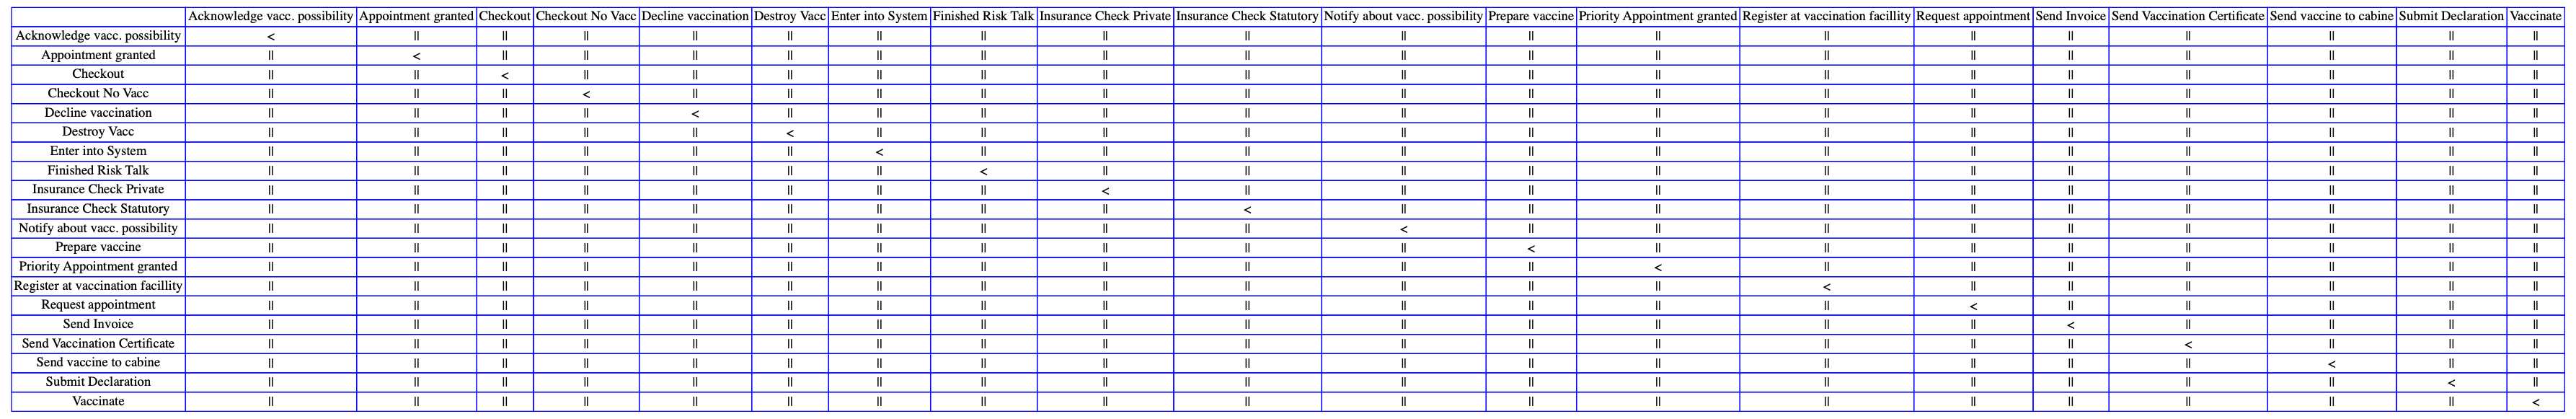

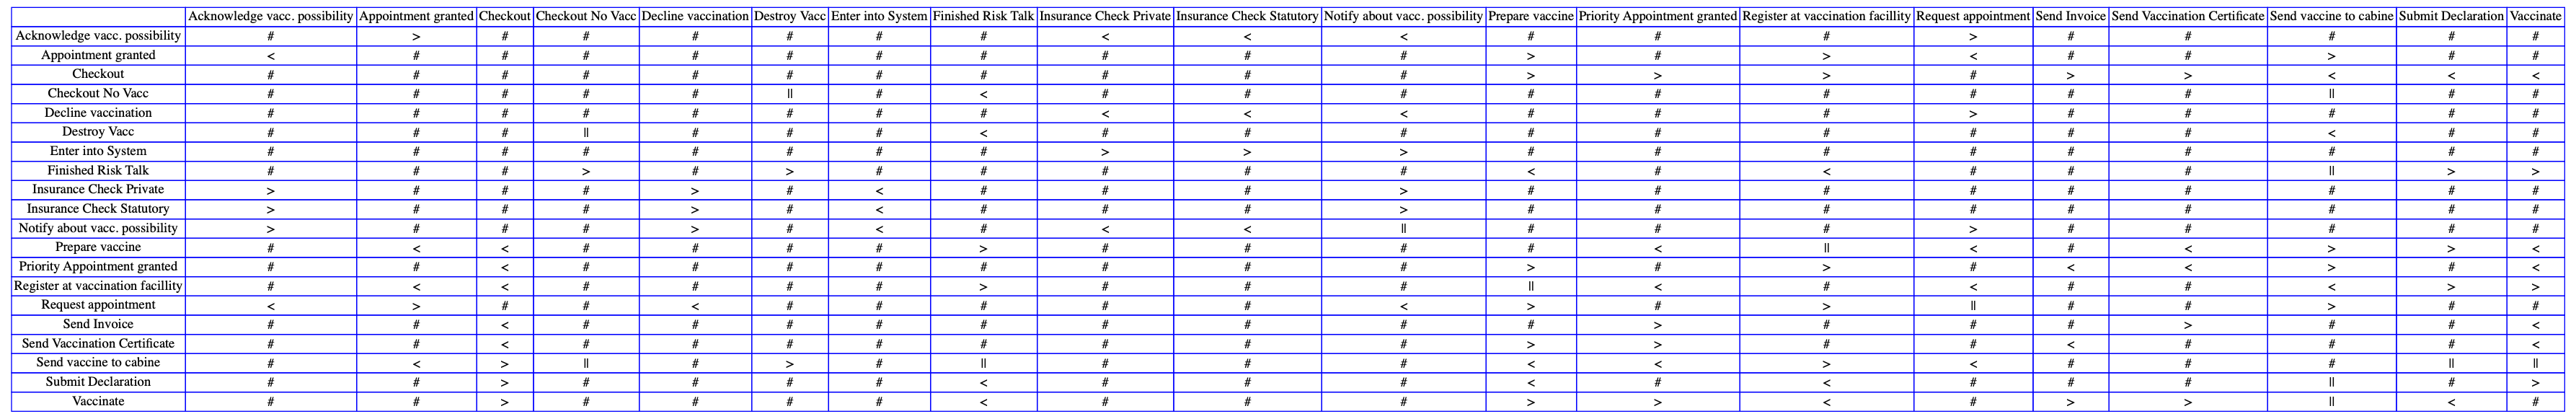

In [53]:
par_constr = len(fp_log.get('parallel'))
print(f'Parallel Constructs (Log): {par_constr}')

par_constr = len(fp_net_flower.get('parallel'))
print(f'Parallel Constructs (Flower Net): {par_constr}')


gviz = fp_visualizer.apply(fp_net_flower, parameters={fp_visualizer.Variants.SINGLE.value.Parameters.FORMAT: "png"})
fp_visualizer.view(gviz)


gviz = fp_visualizer.apply(fp_log, parameters={fp_visualizer.Variants.SINGLE.value.Parameters.FORMAT: "png"})
fp_visualizer.view(gviz)


(C.2) Compare Token-Based Replay and Alignments

parsing log, completed traces :: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 370.39it/s]


Fitness (Alignments): 0.6206853745836236
Fitness (Token-based Replay): 0.9333333333333333


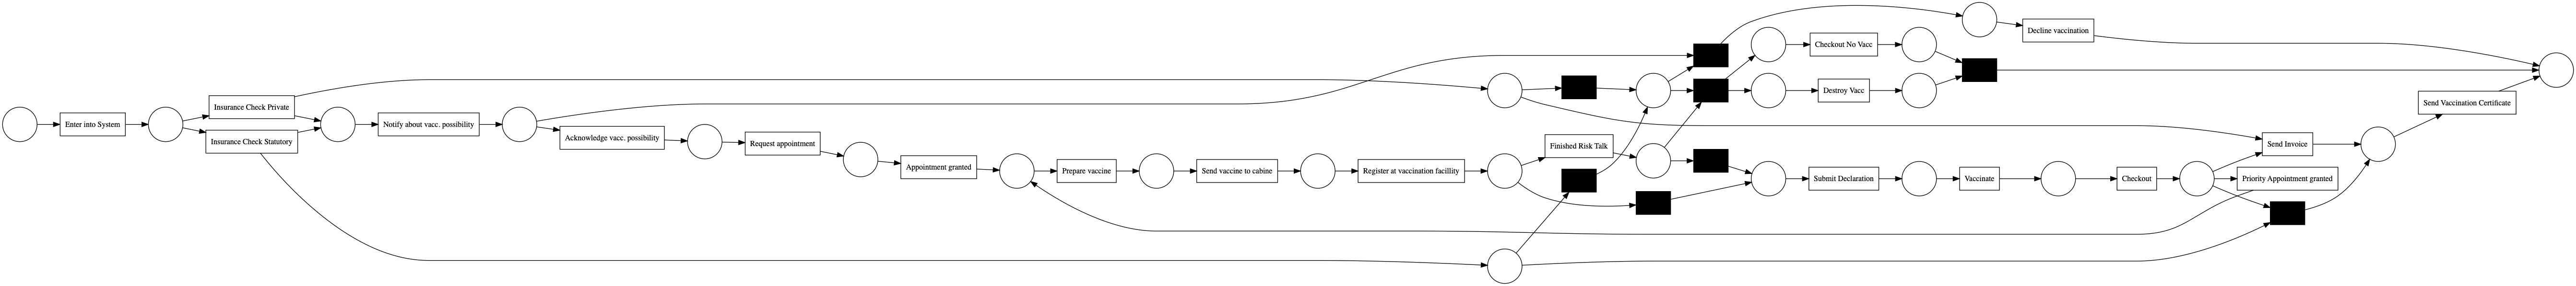

Missing tokens: 2
Remaining tokens:2
Consumed tokens:30
Produced tokens:30


In [54]:
one_trace_log = pm4py.read_xes(os.path.join(LOG_ROOT, "one_trace_log.xes"))

#Conformance using Alignments
aligned_traces_one = alignments.apply_log(one_trace_log, net_m, im3, fm3)
fitness_alignments_one = replay_fitness_evaluator.evaluate(aligned_traces_one, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)['log_fitness']

#Conformance using TB-Replay
replayed_traces_one = token_replay.apply(one_trace_log, net_m, im3, fm3)
fitness_tb_one = replay_fitness_evaluator.evaluate(replayed_traces_one, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)['log_fitness']

print(f'Fitness (Alignments): {fitness_alignments_one}')
print(f'Fitness (Token-based Replay): {fitness_tb_one}')

gviz = pn_visualizer.apply(net_m)
pt_visualizer.view(gviz)

#compuute the number of missing, consumed, remaining and produced tokens
replay_results = pm4py.conformance_diagnostics_token_based_replay(one_trace_log, net_m, im3, fm3)
replay_results
m, c, r, p = 0, 0, 0, 0 #initialize number of tokens
for tr in replay_results:
    m += tr['missing_tokens']
    r+= tr['remaining_tokens']
    c += tr['consumed_tokens']
    p += tr['produced_tokens']

print(f'Missing tokens: {m}\nRemaining tokens:{r}\nConsumed tokens:{c}\nProduced tokens:{p}')

# Question 4: Performance Analysis

#### Read log

In [55]:
log = pm4py.read_xes(os.path.join(LOG_ROOT,"log_resources.xes"))

parsing log, completed traces :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4648/4648 [00:05<00:00, 875.08it/s]


## Q4 (b):  Find activities directly following "Decline vaccination"

In [56]:
events_following_decline = []
num_decline = 0
num_following_decline = 0
for trace in log:
    for i,event in enumerate(trace):
        if event['concept:name'] == 'Decline vaccination':
            num_decline = num_decline +1
            try:
                events_following_decline.append(trace[i+1]['concept:name'])
                num_following_decline = num_following_decline+1
            except IndexError:
                pass
print(set(events_following_decline))
print("Numer of Decline Vaccination: {}".format(num_decline))
print("Numer of cases with activities following Decline Vaccination: {}".format(num_following_decline))

{'Request appointment'}
Numer of Decline Vaccination: 619
Numer of cases with activities following Decline Vaccination: 35


#### Activities following checkout no vaccination

In [57]:
events_following_decline = []
num_decline = 0
num_following_decline = 0
for trace in log:
    for i,event in enumerate(trace):
        if event['concept:name'] == 'Checkout No Vacc':
            num_decline = num_decline +1
            try:
                events_following_decline.append(trace[i+1]['concept:name'])
                num_following_decline = num_following_decline+1
            except IndexError:
                pass
print(set(events_following_decline))
print("Numer of Checkout No Vacc: {}".format(num_decline))
print("Numer of cases with activities following Checkout No Vacc: {}".format(num_following_decline))

{'Send vaccine to cabine', 'Destroy Vacc'}
Numer of Checkout No Vacc: 88
Numer of cases with activities following Checkout No Vacc: 57


## Q4 (c): Root Cause analysis

In [58]:
## The first case in the log
#pd.DataFrame(log[0]).head()

#### Add "illegal" attribute

In [59]:
for trace in log:
    events = []
    for event in trace:
        events.append(event['concept:name'])
    if 'Insurance Check Statutory' in events and 'Send Invoice' in events:
        trace.attributes['illegal'] = True
    else:
        trace.attributes['illegal'] = False

#### Prepare data to train a decision tree

In [60]:
str_event_attributes = ["concept:name", "org:resource"]
str_trace_attributes = ["illegal"]
num_trace_attributes = []
num_event_attributes = []

In [61]:
data, feature_names = get_log_representation.get_representation(
                           log, str_trace_attributes, str_event_attributes,
                           num_trace_attributes, num_event_attributes)

/var/folders/sv/jmmtzklx49g03qzbkrpz_cdr0000gp/T/ipykernel_53046/3043508886.py:1: DeprecatedWarning: get_representation is deprecated as of 2.2.8 and will be removed in 3.0.0. please use pm4py.algo.transformation.log_to_features instead
  data, feature_names = get_log_representation.get_representation(


In [62]:
df = pd.DataFrame(data, columns=feature_names)

In [63]:
df.head()

trace:illegal@False  trace:illegal@True  \
0                    1                   0   
1                    1                   0   
2                    1                   0   
3                    1                   0   
4                    1                   0   

   event:concept:name@Acknowledge vacc. possibility  \
0                                                 0   
1                                                 1   
2                                                 1   
3                                                 1   
4                                                 1   

   event:concept:name@Appointment granted  event:concept:name@Checkout  \
0                                       1                            1   
1                                       1                            1   
2                                       1                            1   
3                                       1                            1   
4                                       1                            1   

   event:concept:name@Checkout No Vacc  \
0                                    0   
1                                    0   
2                                    0   
3                                    0   
4                                    0   

   event:concept:name@Decline vaccination  event:concept:name@Destroy Vacc  \
0                                       1                                0   
1                                       0                                0   
2                                       0                                0   
3                                       0                                0   
4                                       0                                0   

   event:concept:name@Enter into System  \
0                                     1   
1                                     1   
2                                     1   
3                                     1   
4                                     1   

   event:concept:name@Finished Risk Talk  ...  \
0                                      1  ...   
1                                      1  ...   
2                                      1  ...   
3                                      1  ...   
4                                      1  ...   

   event:concept:name@Send vaccine to cabine  \
0                                          1   
1                                          1   
2                                          1   
3                                          1   
4                                          1   

   event:concept:name@Submit Declaration  event:concept:name@Vaccinate  \
0                                      1                             1   
1                                      1                             1   
2                                      1                             1   
3                                      1                             1   
4                                      1                             1   

   event:org:resource@Emil  event:org:resource@Jonas  event:org:resource@Lina  \
0                        0                         0                        0   
1                        0                         0                        0   
2                        1                         0                        0   
3                        0                         1                        1   
4                        0                         0                        0   

   event:org:resource@Luka  event:org:resource@Mia  event:org:resource@Sofia  \
0                        0                       0                         0   
1                        0                       0                         0   
2                        0                       0                         0   
3                        0                       0                         0   
4                        1                       0   

In [64]:
negate = ["trace:illegal@True" , "trace:illegal@False", "event:org:resource@Unknown"]
x_features = [x for x in feature_names if x not in negate]

In [65]:
x_features

['event:concept:name@Acknowledge vacc. possibility',
 'event:concept:name@Appointment granted',
 'event:concept:name@Checkout',
 'event:concept:name@Checkout No Vacc',
 'event:concept:name@Decline vaccination',
 'event:concept:name@Destroy Vacc',
 'event:concept:name@Enter into System',
 'event:concept:name@Finished Risk Talk',
 'event:concept:name@Insurance Check Private',
 'event:concept:name@Insurance Check Statutory',
 'event:concept:name@Notify about vacc. possibility',
 'event:concept:name@Prepare vaccine',
 'event:concept:name@Priority Appointment granted',
 'event:concept:name@Register at vaccination facillity',
 'event:concept:name@Request appointment',
 'event:concept:name@Send Invoice',
 'event:concept:name@Send Vaccination Certificate',
 'event:concept:name@Send vaccine to cabine',
 'event:concept:name@Submit Declaration',
 'event:concept:name@Vaccinate',
 'event:org:resource@Emil',
 'event:org:resource@Jonas',
 'event:org:resource@Lina',
 'event:org:resource@Luka',
 'event

In [66]:
x = df[x_features]
target = df["trace:illegal@True"] 

#### Decision tree

In [67]:
clf = tree.DecisionTreeClassifier()
clf.fit(x, target)

DecisionTreeClassifier()

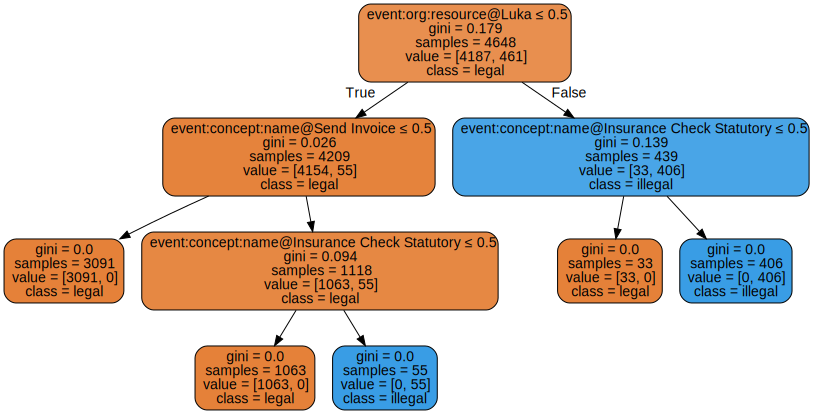

In [68]:
gviz = dectree_visualizer.apply(clf, x_features,["legal", "illegal"])
gviz